# Evaluación 1 - Entrenando redes feedforward

**Autore:**

+ Giovanni Andres Barra Garcia

**Correo Electrónico:**

+ gio.barra@duocuc.cl

**Fecha de Creación:** Abril de 2025  
**Versión:** 1.0  

---

## Descripción

Este notebook contiene el desarrollo de la evaluación 1 de la asignatura de Deep Learning de la carrera de Ingeniería en Informática de DuocUC sede Concepción.

---

## Requisitos de Software

Este notebook fue desarrollado con Python ...

# Carga de datos

In [38]:
!rm -f train-images-idx3-ubyte.gz train-labels-idx1-ubyte.gz t10k-images-idx3-ubyte.gz t10k-labels-idx1-ubyte.gz

!wget https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz


--2025-04-20 19:29:50--  https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.206.207, 209.85.200.207, 74.125.126.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.206.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  --.-KB/s    in 0.04s   

2025-04-20 19:29:50 (270 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2025-04-20 19:29:50--  https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.206.207, 209.85.200.207, 74.125.126.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.206.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [appl

In [39]:
!ls -lh

total 13M
-rw-r--r-- 1 root root 462K Apr 20 19:28 red_sgd_base.h5
-rw-r--r-- 1 root root 497K Apr 20 19:29 red_sgd_capas.h5
drwxr-xr-x 1 root root 4.0K Apr 17 13:36 sample_data
-rw-r--r-- 1 root root 1.6M Apr  6  2017 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 root root 4.5K Apr  6  2017 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 9.5M Apr  6  2017 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root  29K Apr  6  2017 train-labels-idx1-ubyte.gz


In [40]:
import gzip
import shutil
import struct
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from time import time
import pandas as pd
from tabulate import tabulate
from sklearn.metrics import precision_score, f1_score

from tensorflow import keras
# Asegurar que las etiquetas están en formato correcto
from keras.utils import to_categorical

# Carga de imágenes

In [41]:
# Función para cargar imágenes MNIST
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)  # Saltar los primeros 16 bytes del encabezado
    return data.reshape(-1, 28 * 28).astype("float32") / 255.0  # Aplanar y normalizar

# Función para cargar etiquetas MNIST
def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)  # Saltar los primeros 8 bytes del encabezado
    return keras.utils.to_categorical(labels, 10)  # One-hot encoding para clasificación

# Cargar los datos
X_train = load_mnist_images("train-images-idx3-ubyte.gz")
y_train = load_mnist_labels("train-labels-idx1-ubyte.gz")
X_test = load_mnist_images("t10k-images-idx3-ubyte.gz")
y_test = load_mnist_labels("t10k-labels-idx1-ubyte.gz")

# Verificar dimensiones
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: (60000, 784), y_train: (60000, 10)
X_test: (10000, 784), y_test: (10000, 10)


Para este proyecto se utilizó el conjunto de datos MNIST, compuesto por imágenes de dígitos manuscritos. Las imágenes se cargaron desde archivos comprimidos, omitiendo los bytes del encabezado, y luego se aplanaron a vectores de 784 valores y se normalizaron dividiendo por 255 para mejorar el rendimiento del modelo. Las etiquetas se transformaron mediante one-hot encoding para adaptarlas a una red neuronal de clasificación multiclase. Finalmente, se dividieron los datos en conjuntos de entrenamiento y prueba, y se verificaron sus dimensiones para asegurar que el preprocesamiento fue correcto.

# Muestra imágenes

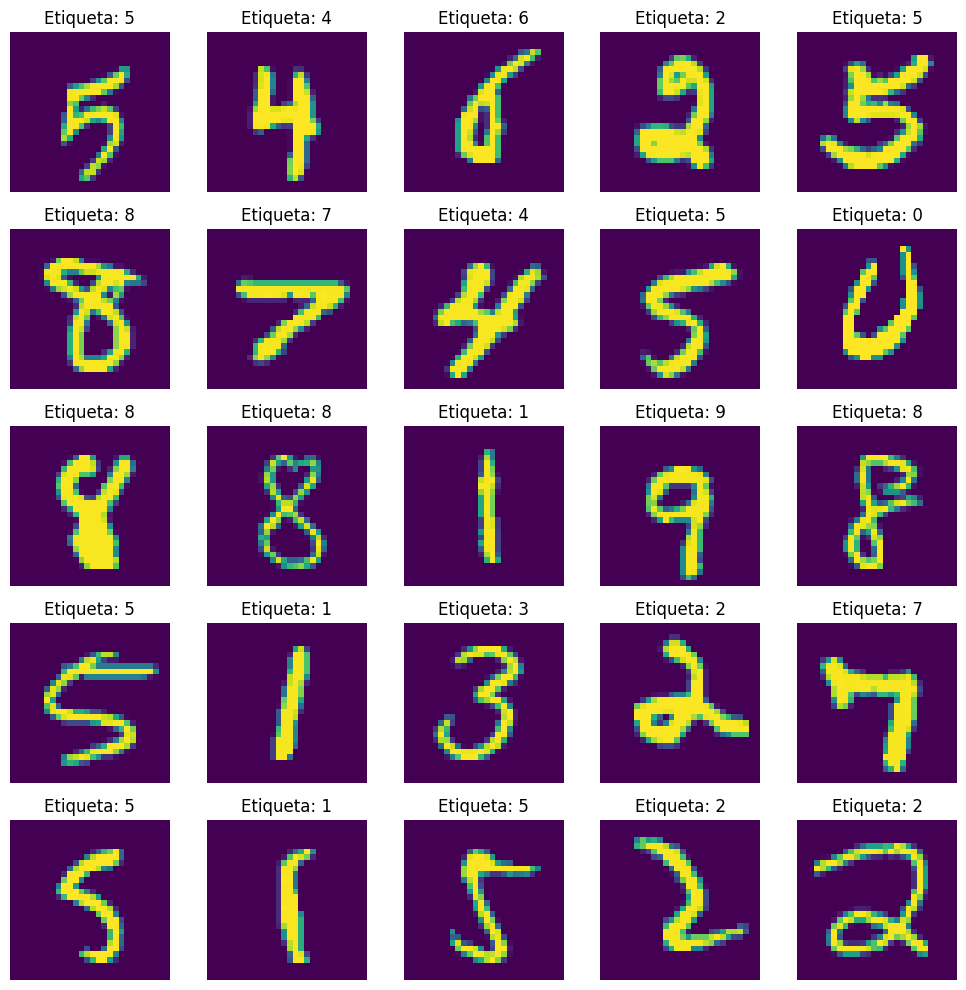

In [42]:
h = 5  # alto de la grilla
w = 5  # ancho de la grilla
fig, axs = plt.subplots(h, w, figsize=(2*w, 2*h))

for i in range(h):
    for j in range(w):
        ex = np.random.randint(len(X_test))
        axs[i, j].imshow(X_test[ex].reshape(28, 28))
        axs[i, j].set_title(f"Etiqueta: {np.argmax(y_test[ex])}")
        axs[i, j].axis('off')  # Oculta los ejes

plt.tight_layout()
plt.show()

In [43]:
M_train = X_train.shape[0]
M_test = X_test.shape[0]

N = X_train.shape[1]
C = y_train.shape[1]

print(N, C, M_train, M_test)

784 10 60000 10000


El valor N = 784 indica que cada imagen ha sido aplanada en un vector de 784 píxeles (28x28). C = 10 representa la cantidad de clases posibles, una para cada dígito del 0 al 9. M_train = 60000 y M_test = 10000 corresponden al número de ejemplos en los conjuntos de entrenamiento y prueba, respectivamente.

# Modelos a utilizar

## SGD

En esta experimentación se utilizara el optimizador Stochastic Gradient Descent (SGD) con enfoque mini-batch, trabajando con un batch base de 64 muestras, y una tasa de aprendizaje (learning rate) inicial de 0.01.

Este valor fue elegido porque es uno de los más comunes y efectivos al comenzar con SGD, especialmente en tareas de clasificación como MNIST, donde se trabaja con imágenes de dígitos del 0 al 9. Muchas librerías, como TensorFlow y PyTorch, lo utilizan como valor por defecto en sus ejemplos y documentación. Además, es una tasa que permite que el modelo aprenda a una buena velocidad sin provocar inestabilidad ni hacer que la función de pérdida aumente en lugar de disminuir.

Por otro lado, al trabajar con mini-batches (por ejemplo, de 32 o 64 datos), se introduce una pequeña variación o "ruido" en el cálculo del gradiente. Esta variación no es negativa, ya que puede ayudar al modelo a generalizar mejor y evitar que memorice los datos de entrenamiento. En este contexto, un learning rate de 0.01 se comporta de forma estable frente a ese nivel de ruido, lo que refuerza su elección como punto de partida.

Se utilizará categorical_crossentropy como función de pérdida ya que se trata de un problema de clasificación multiclase. Además, las etiquetas del conjunto de datos ya se encuentran codificadas en formato one-hot, lo que la convierte en la opción más adecuada para esta tarea.

Se utiliza ReLU como función de activación porque es computacionalmente eficiente y ayuda a que las redes neuronales profundas aprendan más rápido.

Durante la experimentación no se modificará el learning rate, ya que el valor de 0.01 es considerado ideal para comenzar y ha demostrado tener un buen desempeño en tareas con conjuntos de datos como MNIST.

Para la evaluación del rendimiento del modelo, se consideraron principalmente las métricas de accuracy y loss tanto en los conjuntos de entrenamiento como de validación. Estas métricas permitieron comparar objetivamente los modelos generados y seleccionar el que ofreciera un mejor equilibrio entre precisión y generalización. No se utilizaron métricas como F1-score y recall ya que el conjunto de datos MNIST está balanceado y no presenta clases desbalanceadas, por lo que la accuracy resulta ser una métrica suficiente y representativa del rendimiento general del modelo.

**Arquitectura de la red base**
* Optimizador: SGD (Enfoque mini-batch)
* Capas ocultas: 3
* Primera capa: 128 neuronas
* Segunda capa: 64 neuronas
* Tercera capa: 32 neuronas
* Función de activacion: RELU para capas ocultas
* Función de activación: SOFTMAX para la capa de salida
* Learning rate: 0.01
* Loss: categorical_crossentropy
* Metricas: accuracy, Precision, Recall, F1Score

**Entrenamiento de la reed base**
* Epocas: 5
* Batch size: 64

### Arquitectura de la red

In [48]:
# Setea los seed para números random

np.random.seed(10)
tf.random.set_seed(10)


# Se crea la red feed-forward tiene 3 capas escondidas

h1 = 128
h2 = 64
h3 = 32

red_sgd = keras.Sequential(name="SGD")
red_sgd.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd.add(keras.layers.Dense(h1, activation='relu', name='primera_capa'))
red_sgd.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_sgd.add(keras.layers.Dense(h3, activation='relu', name='tercera_capa'))
red_sgd.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_sgd.summary()

red_sgd.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'F1Score'])

Model: "SGD"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ primera_capa (Dense)            │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ segunda_capa (Dense)            │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tercera_capa (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_de_salida (Dense)          │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,146 (434.16 KB)

 Trainable params: 111,146 (434.16 KB)

 Non-trainable params: 0 (0.00 B)

Cantidad de parametros de cada capa

* Para la primera capa: 100.480 = 28 x 28 x 128 +128
* Para la segunda capa: 8.256 =  128 x 64 + 64
* Para la tercera capa: 2.080 = 64 x 32 + 32
* Para la capa de salida: 330 = 32 x 10 + 10

### Entrenamiento de la red

In [49]:
start_time = time()
hist_sgd = red_sgd.fit(X_train, y_train,
        epochs=5,
        batch_size=64,
        validation_data=(X_test,y_test)
        )
end_time = time()
time_base = end_time - start_time
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time - start_time))

red_sgd.save('red_sgd_base.h5')

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - F1Score: 0.5105 - Precision: 0.8760 - Recall: 0.2246 - accuracy: 0.5337 - loss: 1.5476 - val_F1Score: 0.8808 - val_Precision: 0.9268 - val_Recall: 0.8362 - val_accuracy: 0.8823 - val_loss: 0.4213
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - F1Score: 0.8896 - Precision: 0.9303 - Recall: 0.8512 - accuracy: 0.8909 - loss: 0.3898 - val_F1Score: 0.9084 - val_Precision: 0.9329 - val_Recall: 0.8877 - val_accuracy: 0.9095 - val_loss: 0.3126
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - F1Score: 0.9127 - Precision: 0.9384 - Recall: 0.8912 - accuracy: 0.9136 - loss: 0.3035 - val_F1Score: 0.9204 - val_Precision: 0.9395 - val_Recall: 0.9051 - val_accuracy: 0.9213 - val_loss: 0.2682
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - F1Score: 0.9256 - Precision: 0.9444 - Recall: 0.9092 - accuracy: 0.9262 - loss: 0.2618 - val_F1Score: 0.9289 - val_Precision: 0.9449 - val_Recall: 0.9163 - val_accuracy: 0.9296 - val_loss: 0.2380
Epoc

Tiempo de entrenamiento: 32.5827689171 segundos


### Gráficos y conclusiones

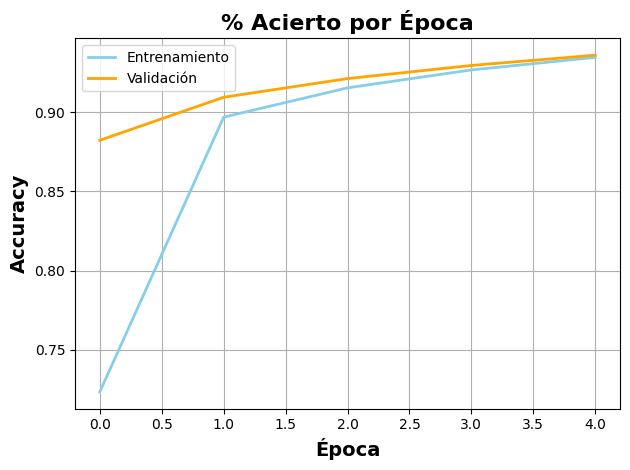

In [50]:
# Gráfica el % de acierto para entrenamiento y validación por época
plt.plot(hist_sgd.history['accuracy'], label='Entrenamiento', color='skyblue', linewidth=2)
plt.plot(hist_sgd.history['val_accuracy'], label='Validación', color='orange', linewidth=2)

plt.title('% Acierto por Época', fontsize=16, fontweight="bold")
plt.xlabel('Época', fontsize=14, fontweight="bold")
plt.ylabel('Accuracy', fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Al analizar el gráfico correspondiente al rendimiento del modelo, se observa que en la primera época el porcentaje de acierto en los datos de entrenamiento es relativamente bajo, lo cual es esperable debido a que es la primera iteración del proceso de aprendizaje. A medida que se incrementa el número de épocas, el modelo mejora progresivamente su desempeño, evidenciando un aumento considerable en la precisión entre la primera y segunda época. Posteriormente, el incremento continúa hasta alcanzar una precisión mas alta cercana al 94% en la quinta época, aunque con mejoras menos pronunciadas conforme avanza el entrenamiento.

En cuanto al conjunto de validación, se destaca que el modelo inicia con un alto porcentaje de acierto desde la primera época, lo cual indica una buena capacidad generalizadora inicial. No obstante, el aumento en la precisión a lo largo de las siguientes épocas es leve, lo que sugiere una estabilización en el desempeño del modelo sobre datos no vistos.


**Grafico de la perdida**

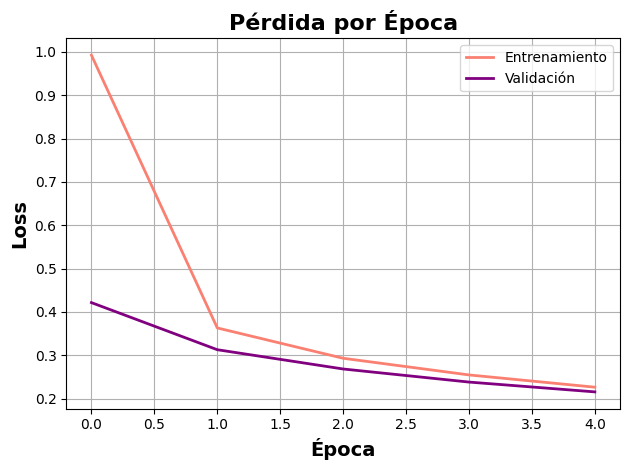

In [51]:
# Gráfica la pérdida (loss) en entrenamiento y validación por época
plt.plot(hist_sgd.history['loss'], label='Entrenamiento', color='salmon', linewidth=2)
plt.plot(hist_sgd.history['val_loss'], label='Validación', color='purple', linewidth=2)

plt.title('Pérdida por Época', fontsize=16, fontweight="bold")
plt.xlabel('Época', fontsize=14, fontweight="bold")
plt.ylabel('Loss', fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

A lo largo de las cinco épocas de entrenamiento, se puede observar que la pérdida en los datos de entrenamiento va disminuyendo de forma progresiva y constante, empezando en 1.4739 y bajando hasta 0.2107. Esta disminución marcada indica que el modelo está aprendiendo correctamente los patrones del conjunto de entrenamiento. Además, la mejora continua en esta métrica sugiere que el modelo no está teniendo problemas para aprender y que el proceso de optimización está funcionando de manera adecuada en cada iteración.

Por otro lado, la pérdida en el conjunto de validación también sigue una tendencia a la baja, pasando de 0.3765 en la primera época a 0.1925 en la quinta. Este comportamiento indica que el modelo no solo está aprendiendo, sino que también está logrando generalizar bien a datos que no ha visto antes. La mejora paralela en ambas métricas (loss y val_loss) refleja un entrenamiento equilibrado, sin señales claras de sobreajuste, lo cual es un resultado positivo en el desarrollo de modelos de redes neuronales.


## SGD (con más capas)

### Arquitectura de la red

In [52]:
# Setea los seed para números random

np.random.seed(10)
tf.random.set_seed(10)


# Se crea la red feed-forward tiene 7 capas escondidas

h1 = 128
h2 = 64
h3 = 32

red_sgd_capas = keras.Sequential(name="SGD")
red_sgd_capas.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_capas.add(keras.layers.Dense(h1, activation='relu', name='primera_capa'))
red_sgd_capas.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_sgd_capas.add(keras.layers.Dense(h3, activation='relu', name='tercera_capa'))
red_sgd_capas.add(keras.layers.Dense(h3, activation='relu', name='cuarta_capa'))
red_sgd_capas.add(keras.layers.Dense(h3, activation='relu', name='quinta_capa'))
red_sgd_capas.add(keras.layers.Dense(h3, activation='relu', name='sexta_capa'))
red_sgd_capas.add(keras.layers.Dense(h3, activation='relu', name='septima_capa'))
red_sgd_capas.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_sgd_capas.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'F1Score'])

### Entrenamiento de la red

In [53]:
start_time_capas = time()
hist_sgd_capas = red_sgd_capas.fit(X_train, y_train,
        epochs=5,
        batch_size=64,
        validation_data=(X_test,y_test)
        )
end_time_capas = time()
time_capas = end_time_capas - start_time_capas
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time_capas - start_time_capas))

red_sgd_capas.save('red_sgd_capas.h5')

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - F1Score: 0.2084 - Precision: 0.5554 - Recall: 0.0366 - accuracy: 0.2641 - loss: 2.0725 - val_F1Score: 0.7680 - val_Precision: 0.8426 - val_Recall: 0.6955 - val_accuracy: 0.7695 - val_loss: 0.7054
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - F1Score: 0.8105 - Precision: 0.8699 - Recall: 0.7573 - accuracy: 0.8137 - loss: 0.6003 - val_F1Score: 0.8822 - val_Precision: 0.9143 - val_Recall: 0.8573 - val_accuracy: 0.8837 - val_loss: 0.4081
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - F1Score: 0.8954 - Precision: 0.9224 - Recall: 0.8727 - accuracy: 0.8966 - loss: 0.3621 - val_F1Score: 0.9127 - val_Precision: 0.9330 - val_Recall: 0.8970 - val_accuracy: 0.9140 - val_loss: 0.3068
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - F1Score: 0.9248 - Precision: 0.9432 - Recall: 0.9108 - accuracy: 0.9254 - loss: 0.2644 - val_F1Score: 0.9314 - val_Precision: 0.9464 - val_Recall: 0.9214 - val_accuracy: 0.9323 - val_loss: 0.2494
Epo

Tiempo de entrenamiento: 42.1133787632 segundos


### Tabla comparativa y conclusión

In [54]:
# Extraer métricas de ENTRENAMIENTO de ambos modelos
accuracy_base = hist_sgd.history['accuracy'][-1] * 100
f1_score_base = hist_sgd.history['F1Score'][-1][-1]
loss_base = hist_sgd.history['loss'][-1]
precision_base = hist_sgd.history['Precision'][-1]

accuracy_capas = hist_sgd_capas.history['accuracy'][-1] * 100
f1_score_capas = hist_sgd_capas.history['F1Score'][-1][-1]
loss_capas = hist_sgd_capas.history['loss'][-1]
precision_capas = hist_sgd_capas.history['Precision'][-1]

# Extraer métricas de VALIDACIÓN de ambos modelos
val_accuracy_base = hist_sgd.history['val_accuracy'][-1] * 100
val_f1_score_base = hist_sgd.history['val_F1Score'][-1][-1]
val_loss_base = hist_sgd.history['val_loss'][-1]
val_precision_base = hist_sgd.history['val_Precision'][-1]

val_accuracy_capas = hist_sgd_capas.history['val_accuracy'][-1] * 100
val_f1_score_capas = hist_sgd_capas.history['val_F1Score'][-1][-1]
val_loss_capas = hist_sgd_capas.history['val_loss'][-1]
val_precision_capas = hist_sgd_capas.history['val_Precision'][-1]

# Índices de filas
index = [
    'Capas ocultas',
    'Optimizer',
    'Épocas',
    'Batch size',
    'Activación',
    'Tiempo entrenamiento aprox.',
    'Accuracy final',
    'F1-Score final',
    'Precision final',
    'Loss final'
]

# Datos Red Base (original)
red_base_entrenamiento = [
    '3 (128 → 64 → 32)',
    'SGD (lr=0.01)',
    '5',
    '64',
    'Relu',
    f'{time_base:.2f} segundos',
    f'{accuracy_base:.2f}%',
    f'{f1_score_base:.4f}',
    f'{precision_base:.4f}',
    f'{loss_base:.4f}'
]

red_base_validacion = [
    '3 (128 → 64 → 32)',
    'SGD (lr=0.01)',
    '5',
    '64',
    'Relu',
    f'{time_base:.2f} segundos',
    f'{val_accuracy_base:.2f}%',
    f'{val_f1_score_base:.4f}',
    f'{val_precision_base:.4f}',
    f'{val_loss_base:.4f}'
]

# Datos Red con Más Épocas
red_capas_entrenamiento = [
    '7 (128 → 64 → 32 x 5)',
    'SGD (lr=0.01)',
    '5',
    '64',
    'Relu',
    f'{time_capas:.2f} segundos',
    f'{accuracy_capas:.2f}%',
    f'{f1_score_capas:.4f}',
    f'{precision_capas:.4f}',
    f'{loss_capas:.4f}'
]

red_capas_validacion = [
    '7 (128 → 64 → 32 x 5)',
    'SGD (lr=0.01)',
    '5',
    '64',
    'Relu',
    f'{time_capas:.2f} segundos',
    f'{val_accuracy_capas:.2f}%',
    f'{val_f1_score_capas:.4f}',
    f'{val_precision_capas:.4f}',
    f'{val_loss_capas:.4f}'
]

# Simular combinación de celdas para las primeras 3 filas en la Red Base
red_base_entrenamiento_mod = red_base_entrenamiento.copy()
red_base_validacion_mod = red_base_validacion.copy()

for i in range(6):  # 'Capas ocultas', 'Optimizer', 'Épocas'
    red_base_validacion_mod[i] = ''  # Dejar vacío para que parezca fusionado visualmente

# Simular combinación de celdas para las primeras 3 filas en la Red con Más Capas
red_capas_entrenamiento_mod = red_capas_entrenamiento.copy()
red_capas_validacion_mod = red_capas_validacion.copy()

for i in range(6):  # 'Capas ocultas', 'Optimizer', 'Épocas'
    red_capas_validacion_mod[i] = ''  # Dejar vacío para que parezca fusionado visualmente

# Crear MultiIndex para las columnas
columnas = pd.MultiIndex.from_product(
    [['Red Base', 'Red con Más capas'], ['Entrenamiento', 'Validación']],
    names=['Modelo', 'Tipo']
)

# Crear DataFrame con los datos
data = list(zip(
    red_base_entrenamiento_mod, red_base_validacion_mod,
    red_capas_entrenamiento_mod, red_capas_validacion_mod
))

comparacion_capas_df = pd.DataFrame(data, index=index, columns=columnas)

# Mostrar la tabla
display(comparacion_capas_df)

Modelo                                Red Base             \
Tipo                             Entrenamiento Validación   
Capas ocultas                3 (128 → 64 → 32)              
Optimizer                        SGD (lr=0.01)              
Épocas                                       5              
Batch size                                  64              
Activación                                Relu              
Tiempo entrenamiento aprox.     32.58 segundos              
Accuracy final                          93.47%     93.61%   
F1-Score final                          0.9094     0.9069   
Precision final                         0.9505     0.9499   
Loss final                              0.2261     0.2153   

Modelo                           Red con Más capas             
Tipo                                 Entrenamiento Validación  
Capas ocultas                7 (128 → 64 → 32 x 5)             
Optimizer                            SGD (lr=0.01)             
Épocas                                           5             
Batch size                                      64             
Activación                                    Relu             
Tiempo entrenamiento aprox.         42.11 segundos             
Accuracy final                              94.19%     93.83%  
F1-Score final                              0.9158     0.9051  
Precision final                             0.9545     0.9510  
Loss final                                  0.2032     0.2179

En esta tabla se presenta la variabilidad de los resultados de entrenamiento y validación de redes con la misma arquitectura, diferenciadas únicamente por la cantidad de capas ocultas. Para una mejor visualización de estas diferencias en las métricas, se utilizarán gráficos de barras que permitirán comparar de manera clara el impacto de estos parámetros en el desempeño del modelo.

### Grafico comparativo de métricas y conclusión

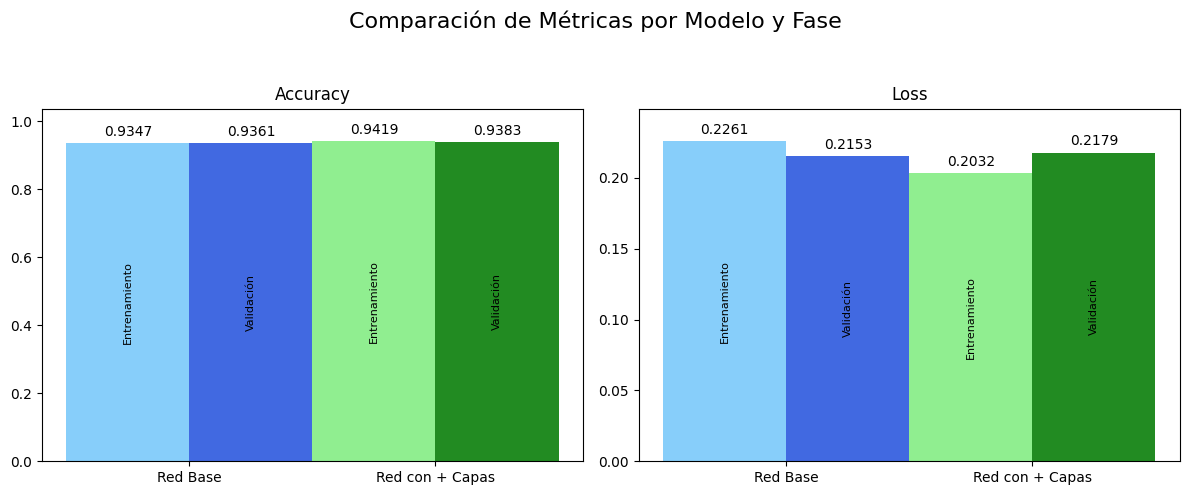

In [56]:
# Definir solo las métricas necesarias
metricas = ['Accuracy', 'Loss']

# Datos de entrenamiento y validación (solo accuracy y loss)
base_modelo_entrenamiento = [accuracy_base / 100, loss_base]
modelo_con_capas_entrenamiento = [accuracy_capas / 100, loss_capas]

base_modelo_validacion = [val_accuracy_base / 100, val_loss_base]
modelo_con_capas_validacion = [val_accuracy_capas / 100, val_loss_capas]

# Ancho de cada barra
bar_width = 0.2

# Función para agregar etiquetas
def agregar_etiquetas(ax, bars, fase):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
        ax.text(bar.get_x() + bar.get_width() / 2, height / 2,
                f'{fase}', ha='center', va='center',
                rotation=90, fontsize=8, color='black')

# Crear figura y ejes (2 métricas = 1 fila, 2 columnas)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Comparación de Métricas por Modelo y Fase', fontsize=16)

# Métricas por subplot
titulos = ['Accuracy', 'Loss']
indices = [0, 1]

for i, idx in enumerate(indices):
    ax = axs[i]
    ax.set_title(titulos[i])

    # Valores
    valores = [
        base_modelo_entrenamiento[idx],
        base_modelo_validacion[idx],
        modelo_con_capas_entrenamiento[idx],
        modelo_con_capas_validacion[idx]
    ]

    pos = np.arange(4) * bar_width

    colores = ['lightskyblue', 'royalblue', 'lightgreen', 'forestgreen']
    etiquetas_fase = ['Entrenamiento', 'Validación', 'Entrenamiento', 'Validación']
    etiquetas_xtick = ['Red Base', 'Red con + Capas']
    tick_pos = [pos[0] + bar_width / 2, pos[2] + bar_width / 2]

    for j in range(4):
        bar = ax.bar(pos[j], valores[j], width=bar_width, color=colores[j])
        agregar_etiquetas(ax, bar, etiquetas_fase[j])

    ax.set_xticks(tick_pos)
    ax.set_xticklabels(etiquetas_xtick)
    ax.set_ylim(0, max(valores) * 1.1)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

En el gráfico de comparación de accuracy, se observa que la diferencia entre los dos modelos es inferior a un punto porcentual, lo que sugiere que la discrepancia en el rendimiento entre ambas redes es mínima. Por otro lado, en el gráfico de comparación de loss, se puede apreciar que el modelo con más capas presenta una pérdida ligeramente menor. Sin embargo, la brecha entre ambos modelos es también pequeña. Debido a esta diferencia marginal en el rendimiento, se decide evaluar los tiempos de entrenamiento de cada modelo para tomar una decisión más informada sobre cuál es el modelo más eficiente.

**Gráfico de comparacion de tiempos de entrenamiento entre la Red Base y la Red con más capas**

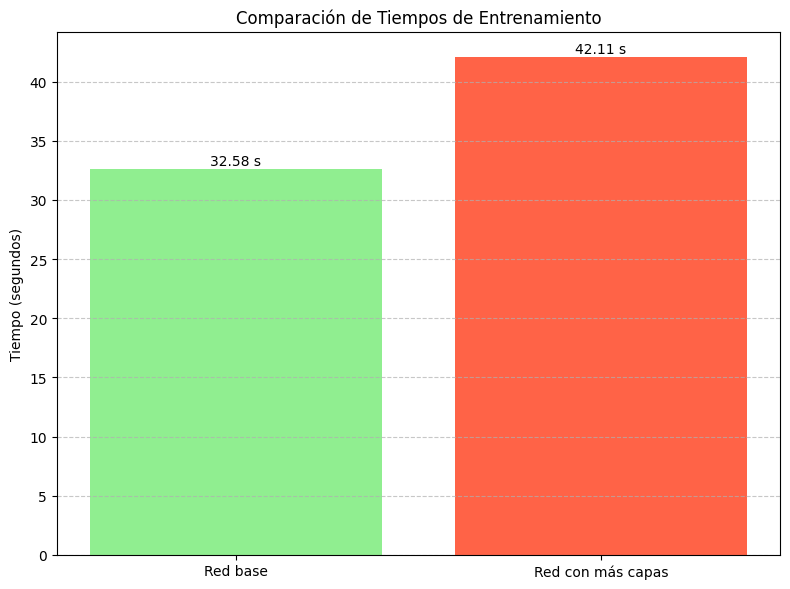

In [57]:
# Etiquetas y valores
labels = ['Red base', 'Red con más capas']
tiempos = [time_base, time_capas]

# Crear gráfico de barras
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, tiempos, color=['lightgreen', 'tomato'])

# Agregar valores encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{yval:.2f} s', ha='center', va='bottom')

# Estética
plt.title('Comparación de Tiempos de Entrenamiento')
plt.ylabel('Tiempo (segundos)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Se observa que la red con mayor cantidad de capas presenta un costo computacional más elevado. Esto sugiere que, a medida que se incrementa la profundidad del modelo, también lo hace el tiempo requerido para su entrenamiento. En función de estos resultados, la selección del modelo más adecuado se realiza considerando el tiempo de entrenamiento como criterio principal. Dado que ambos modelos alcanzan un accuracy alto y con diferencias mínimas, resulta más conveniente optar por el modelo que ofrezca un mejor rendimiento computacional, especialmente si se proyecta escalar el modelo con más capas en futuras iteraciones.

## SGD (con más epocas)

### Arquitectura de la red

In [61]:
# Setea los seed para números random

np.random.seed(10)
tf.random.set_seed(10)


# Se crea la red feed-forward tiene 3 capas escondidas

h1 = 128
h2 = 64
h3 = 32

red_sgd_epocas = keras.Sequential(name="SGD")
red_sgd_epocas.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_epocas.add(keras.layers.Dense(h1, activation='relu', name='primera_capa'))
red_sgd_epocas.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_sgd_epocas.add(keras.layers.Dense(h3, activation='relu', name='tercera_capa'))
red_sgd_epocas.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_sgd_epocas.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'F1Score'])

### Entrenamiento de la red

In [62]:
start_time_epocas = time()
hist_sgd_epocas = red_sgd_epocas.fit(X_train, y_train,
        epochs=15,
        batch_size=64,
        validation_data=(X_test,y_test)
        )
end_time_epocas = time()
time_epocas = end_time_epocas - start_time_epocas
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time_epocas - start_time_epocas))

red_sgd_epocas.save('red_sgd_epocas.h5')

Epoch 1/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - F1Score: 0.4981 - Precision: 0.8647 - Recall: 0.2293 - accuracy: 0.5135 - loss: 1.5381 - val_F1Score: 0.8830 - val_Precision: 0.9269 - val_Recall: 0.8388 - val_accuracy: 0.8846 - val_loss: 0.4129
Epoch 2/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - F1Score: 0.8904 - Precision: 0.9307 - Recall: 0.8536 - accuracy: 0.8918 - loss: 0.3822 - val_F1Score: 0.9087 - val_Precision: 0.9359 - val_Recall: 0.8889 - val_accuracy: 0.9100 - val_loss: 0.3076
Epoch 3/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - F1Score: 0.9129 - Precision: 0.9369 - Recall: 0.8914 - accuracy: 0.9138 - loss: 0.2987 - val_F1Score: 0.9209 - val_Precision: 0.9420 - val_Recall: 0.9054 - val_accuracy: 0.9220 - val_loss: 0.2649
Epoch 4/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - F1Score: 0.9249 - Precision: 0.9447 - Recall: 0.9080 - accuracy: 0.9256 - loss: 0.2570 - val_F1Score: 0.9291 - val_Precision: 0.9473 - val_Recall: 0.9169 - val_accuracy: 0.9299 - val_loss: 0.2354

Tiempo de entrenamiento: 81.2840356827 segundos


### Tablas comparativas y gráficos

In [66]:
# Extraer métricas de ENTRENAMIENTO de ambos modelos
accuracy_base = hist_sgd.history['accuracy'][-1] * 100
f1_score_base = hist_sgd.history['F1Score'][-1][-1]
loss_base = hist_sgd.history['loss'][-1]
precision_base = hist_sgd.history['Precision'][-1]

accuracy_epocas = hist_sgd_epocas.history['accuracy'][-1] * 100
f1_score_epocas = hist_sgd_epocas.history['F1Score'][-1][-1]
loss_epocas = hist_sgd_epocas.history['loss'][-1]
precision_epocas = hist_sgd_epocas.history['Precision'][-1]

# Extraer métricas de VALIDACIÓN de ambos modelos
val_accuracy_base = hist_sgd.history['val_accuracy'][-1] * 100
val_f1_score_base = hist_sgd.history['val_F1Score'][-1][-1]
val_loss_base = hist_sgd.history['val_loss'][-1]
val_precision_base = hist_sgd.history['val_Precision'][-1]

val_accuracy_epocas = hist_sgd_epocas.history['val_accuracy'][-1] * 100
val_f1_score_epocas = hist_sgd_epocas.history['val_F1Score'][-1][-1]
val_loss_epocas = hist_sgd_epocas.history['val_loss'][-1]
val_precision_epocas = hist_sgd_epocas.history['val_Precision'][-1]

# Índices de filas
index = [
    'Capas ocultas',
    'Optimizer',
    'Épocas',
    'Batch size',
    'Activación',
    'Tiempo entrenamiento aprox.',
    'Accuracy final',
    'F1-Score final',
    'Precision final',
    'Loss final'
]

# Datos Red Base (original)
red_base_entrenamiento = [
    '3 (128 → 64 → 32)',
    'SGD (lr=0.01)',
    '5',
    '64',
    'Relu',
    f'{time_base:.2f} segundos',
    f'{accuracy_base:.2f}%',
    f'{f1_score_base:.4f}',
    f'{precision_base:.4f}',
    f'{loss_base:.4f}'
]

red_base_validacion = [
    '3 (128 → 64 → 32)',
    'SGD (lr=0.01)',
    '5',
    '64',
    'Relu',
    f'{time_base:.2f} segundos',
    f'{val_accuracy_base:.2f}%',
    f'{val_f1_score_base:.4f}',
    f'{val_precision_base:.4f}',
    f'{val_loss_base:.4f}'
]

# Datos Red con Más Épocas
red_epocas_entrenamiento = [
    '3 (128 → 64 → 32)',
    'SGD (lr=0.01)',
    '15',
    '64',
    'Relu',
    f'{time_epocas:.2f} segundos',
    f'{accuracy_epocas:.2f}%',
    f'{f1_score_epocas:.4f}',
    f'{precision_epocas:.4f}',
    f'{loss_epocas:.4f}'
]

red_epocas_validacion = [
    '3 (128 → 64 → 32)',
    'SGD (lr=0.01)',
    '15',
    '64',
    'Relu',
    f'{time_epocas:.2f} segundos',
    f'{val_accuracy_epocas:.2f}%',
    f'{val_f1_score_epocas:.4f}',
    f'{val_precision_epocas:.4f}',
    f'{val_loss_epocas:.4f}'
]

# Simular combinación de celdas para las primeras 3 filas en la Red Base
red_base_entrenamiento_mod = red_base_entrenamiento.copy()
red_base_validacion_mod = red_base_validacion.copy()

for i in range(6):  # 'Capas ocultas', 'Optimizer', 'Épocas'
    red_base_validacion_mod[i] = ''  # Dejar vacío para que parezca fusionado visualmente

# Simular combinación de celdas para las primeras 3 filas en la Red con Más Capas
red_epocas_entrenamiento_mod = red_epocas_entrenamiento.copy()
red_epocas_validacion_mod = red_epocas_validacion.copy()

for i in range(6):  # 'Capas ocultas', 'Optimizer', 'Épocas'
    red_epocas_validacion_mod[i] = ''  # Dejar vacío para que parezca fusionado visualmente

# Crear MultiIndex para las columnas
columnas = pd.MultiIndex.from_product(
    [['Red Base', 'Red con Más Épocas'], ['Entrenamiento', 'Validación']],
    names=['Modelo', 'Tipo']
)

# Crear DataFrame con los datos
data = list(zip(
    red_base_entrenamiento_mod, red_base_validacion_mod,
    red_epocas_entrenamiento_mod, red_epocas_validacion_mod
))

comparacion_epocas_df = pd.DataFrame(data, index=index, columns=columnas)

# Mostrar la tabla
display(comparacion_epocas_df)

Modelo                                Red Base            Red con Más Épocas  \
Tipo                             Entrenamiento Validación      Entrenamiento   
Capas ocultas                3 (128 → 64 → 32)             3 (128 → 64 → 32)   
Optimizer                        SGD (lr=0.01)                 SGD (lr=0.01)   
Épocas                                       5                            15   
Batch size                                  64                            64   
Activación                                Relu                          Relu   
Tiempo entrenamiento aprox.     32.58 segundos                81.28 segundos   
Accuracy final                          93.47%     93.61%             97.11%   
F1-Score final                          0.9094     0.9069             0.9547   
Precision final                         0.9505     0.9499             0.9768   
Loss final                              0.2261     0.2153             0.1037   

Modelo                                  
Tipo                        Validación  
Capas ocultas                           
Optimizer                               
Épocas                                  
Batch size                              
Activación                              
Tiempo entrenamiento aprox.             
Accuracy final                  96.23%  
F1-Score final                  0.9505  
Precision final                 0.9689  
Loss final                      0.1200

La siguiente tabla comparativa presenta los resultados obtenidos por ambos modelos, lo cual permite establecer una base para su análisis. En la sección posterior, se incluyen gráficos comparativos que facilitan la visualización de las métricas y permiten una mejor comprensión del comportamiento de cada red.

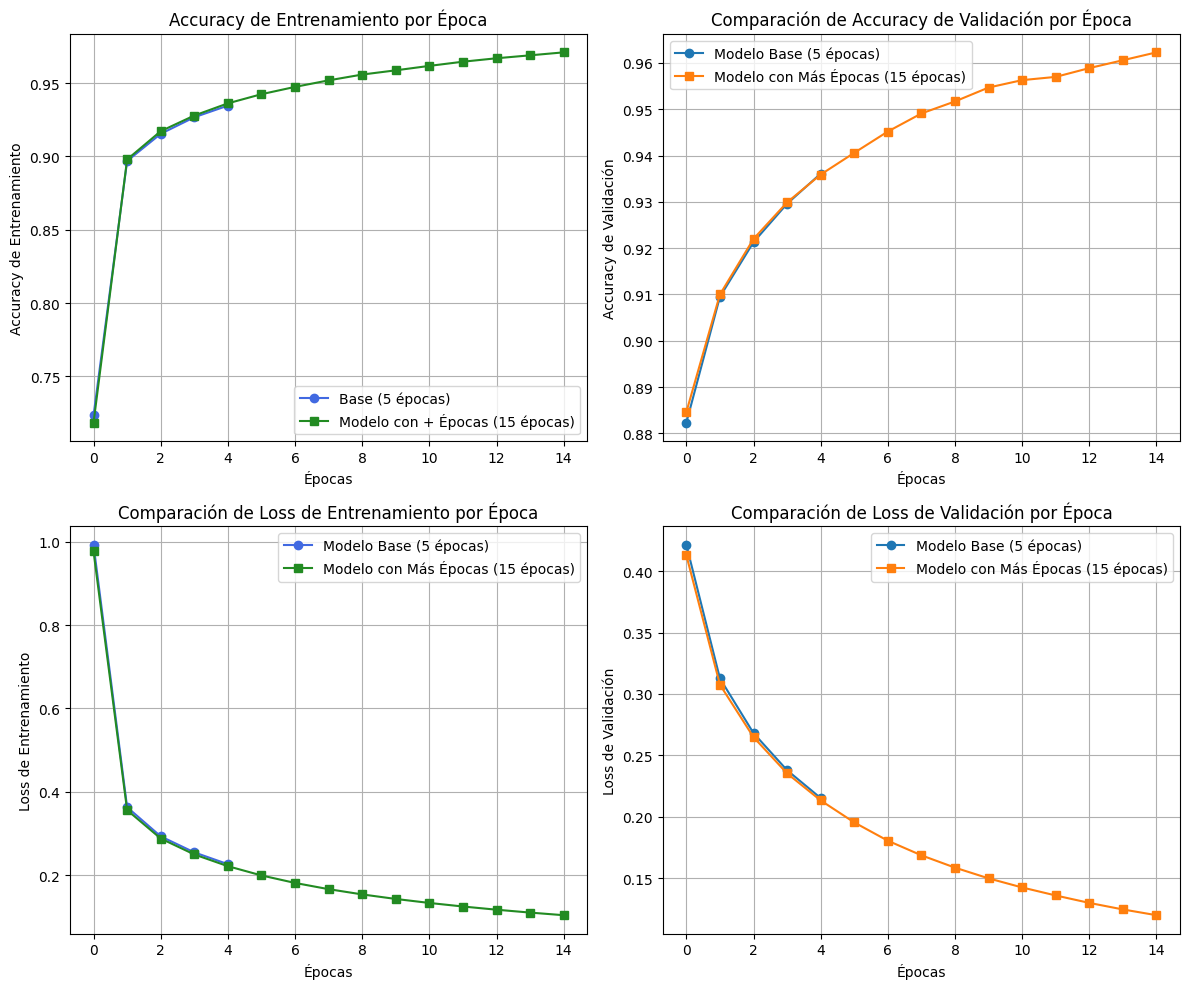

In [67]:
# Variables de precisión de entrenamiento
acc_base_entrenamiento = hist_sgd.history['accuracy']
acc_epocas_entrenamiento = hist_sgd_epocas.history['accuracy']

# Variables de precisión de validación
acc_base = hist_sgd.history['val_accuracy']
acc_epocas = hist_sgd_epocas.history['val_accuracy']

# Variables de pérdida de entrenamiento
loss_base_entrenamiento = hist_sgd.history['loss']
loss_epocas_entrenamiento = hist_sgd_epocas.history['loss']

# Variables de pérdida de validación
loss_base = hist_sgd.history['val_loss']
loss_epocas = hist_sgd_epocas.history['val_loss']

# Crear la figura con una cuadrícula de 2x2
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Gráfico 1: Accuracy de entrenamiento
axs[0, 0].plot(acc_base_entrenamiento, label='Base (5 épocas)', marker='o', color='royalblue')
axs[0, 0].plot(acc_epocas_entrenamiento, label='Modelo con + Épocas (15 épocas)', marker='s', color='forestgreen')
axs[0, 0].set_title('Accuracy de Entrenamiento por Época')
axs[0, 0].set_xlabel('Épocas')
axs[0, 0].set_ylabel('Accuracy de Entrenamiento')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Gráfico 2: Accuracy de validación
axs[0, 1].plot(acc_base, label='Modelo Base (5 épocas)', marker='o')
axs[0, 1].plot(acc_epocas, label='Modelo con Más Épocas (15 épocas)', marker='s')
axs[0, 1].set_title('Comparación de Accuracy de Validación por Época')
axs[0, 1].set_xlabel('Épocas')
axs[0, 1].set_ylabel('Accuracy de Validación')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Gráfico 3: Loss de entrenamiento
axs[1, 0].plot(loss_base_entrenamiento, label='Modelo Base (5 épocas)', marker='o', color='royalblue')
axs[1, 0].plot(loss_epocas_entrenamiento, label='Modelo con Más Épocas (15 épocas)', marker='s', color='forestgreen')
axs[1, 0].set_title('Comparación de Loss de Entrenamiento por Época')
axs[1, 0].set_xlabel('Épocas')
axs[1, 0].set_ylabel('Loss de Entrenamiento')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Gráfico 4: Loss de validación
axs[1, 1].plot(loss_base, label='Modelo Base (5 épocas)', marker='o')
axs[1, 1].plot(loss_epocas, label='Modelo con Más Épocas (15 épocas)', marker='s')
axs[1, 1].set_title('Comparación de Loss de Validación por Época')
axs[1, 1].set_xlabel('Épocas')
axs[1, 1].set_ylabel('Loss de Validación')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Ajustar el layout para evitar el solapamiento de etiquetas
plt.tight_layout()
plt.show()

Al analizar los gráficos de accuracy de entrenamiento y validación correspondientes a dos redes entrenadas con diferente cantidad de épocas, se observa una tendencia creciente en el desempeño a medida que aumenta el número de épocas. Específicamente, el accuracy mejora de forma progresiva durante las primeras iteraciones del entrenamiento. Sin embargo, en las últimas épocas, esta mejora se vuelve marginal, con incrementos inferiores a un punto porcentual por época, lo que indica una tendencia hacia la estabilización del modelo.

Al analizar los gráficos de loss de entrenamiento y validación correspondientes a dos redes entrenadas con diferente cantidad de épocas, se observa una tendencia decreciente en la función de pérdida a medida que avanza el proceso de entrenamiento. Específicamente, el valor de loss disminuye de forma progresiva durante las primeras épocas, reflejando una mejora en la capacidad del modelo para ajustarse a los datos. No obstante, en las últimas iteraciones, esta disminución se vuelve marginal, con reducciones poco significativas entre épocas, lo que sugiere una estabilización en el proceso de aprendizaje del modelo.

**Conclusión**

Se considera que el modelo entrenado con un mayor número de épocas es más adecuado, ya que presenta un mejor ajuste a los datos sin evidencias significativas de sobreajuste. Además, la red con más épocas muestra una menor pérdida (loss), lo que indica una mejora en la optimización del modelo. Aunque el tiempo de entrenamiento es mayor, este incremento se ve compensado por un mejor rendimiento general del modelo. A pesar de que las mejoras en las métricas se vuelven marginales en las últimas iteraciones, estos pequeños incrementos reflejan una estabilización en el proceso de aprendizaje, lo que contribuye a la formación de un modelo más robusto y con mayor capacidad de generalización.

## SGD (con cambio en el batch size)

### Arquitectura de la red

In [68]:
# Setea los seed para números random

np.random.seed(10)
tf.random.set_seed(10)


# Se crea la red feed-forward tiene 3 capas escondidas

h1 = 128
h2 = 64
h3 = 32

red_sgd_batchsize = keras.Sequential(name="SGD")
red_sgd_batchsize.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_batchsize.add(keras.layers.Dense(h1, activation='relu', name='primera_capa'))
red_sgd_batchsize.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_sgd_batchsize.add(keras.layers.Dense(h3, activation='relu', name='tercera_capa'))
red_sgd_batchsize.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_sgd_batchsize.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'F1Score'])

### entrenamiento de la red

In [69]:
start_time_batchsize = time()
hist_sgd_batchzise = red_sgd_batchsize.fit(X_train, y_train,
        epochs=15,
        batch_size=32,
        validation_data=(X_test,y_test)
        )
end_time_batchsize = time()
time_batchsize = end_time_batchsize - start_time_batchsize
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time_batchsize - start_time_batchsize))

red_sgd_batchsize.save('red_sgd_batchsize.h5')

Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - F1Score: 0.6486 - Precision: 0.8717 - Recall: 0.4123 - accuracy: 0.6627 - loss: 1.1543 - val_F1Score: 0.9022 - val_Precision: 0.9264 - val_Recall: 0.8812 - val_accuracy: 0.9037 - val_loss: 0.3261
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - F1Score: 0.9126 - Precision: 0.9366 - Recall: 0.8935 - accuracy: 0.9137 - loss: 0.3026 - val_F1Score: 0.9255 - val_Precision: 0.9436 - val_Recall: 0.9112 - val_accuracy: 0.9263 - val_loss: 0.2501
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - F1Score: 0.9325 - Precision: 0.9502 - Recall: 0.9197 - accuracy: 0.9332 - loss: 0.2339 - val_F1Score: 0.9372 - val_Precision: 0.9531 - val_Recall: 0.9268 - val_accuracy: 0.9379 - val_loss: 0.2060
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - F1Score: 0.9440 - Precision: 0.9581 - Recall: 0.9338 - accuracy: 0.9445 - loss: 0.1916 - val_F1Score: 0.9478 - val_Precision: 0.9595 - val_Recall: 0.9382 - val_accuracy: 0.9483 - val_loss

Tiempo de entrenamiento: 141.3200464249 segundos


### gráficos y conclusiones

**Gráfico de diferencia de accuracy en entrenamiento y validación de red con batch size 64 y red con batch size de 32**

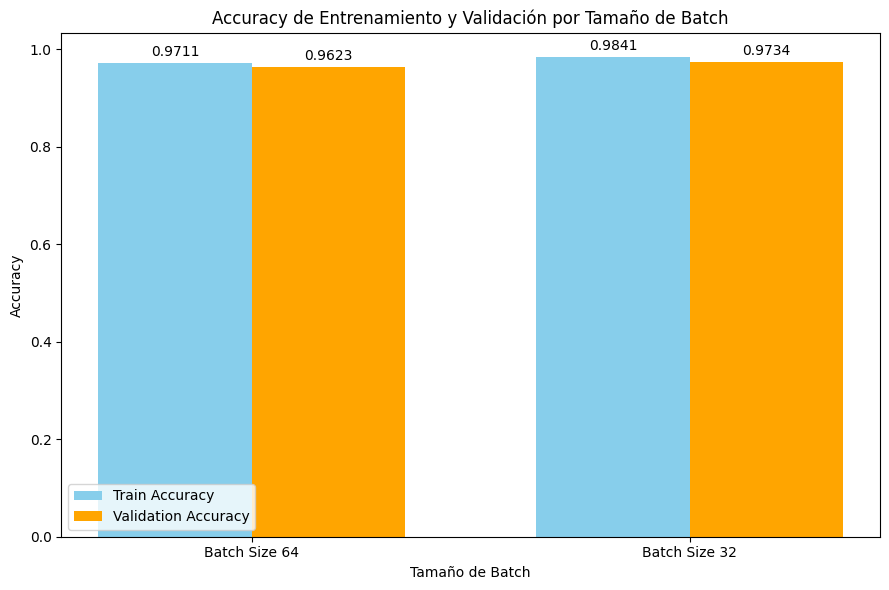

In [70]:
# Extraemos los accuracies de entrenamiento y validación para ambos modelos
train_acc_64 = hist_sgd_epocas.history['accuracy'][-1]
val_acc_64 = hist_sgd_epocas.history['val_accuracy'][-1]

train_acc_32 = hist_sgd_batchzise.history['accuracy'][-1]
val_acc_32 = hist_sgd_batchzise.history['val_accuracy'][-1]

# Datos
labels = ['Batch Size 64', 'Batch Size 32']
train_accuracies = [train_acc_64, train_acc_32]
val_accuracies = [val_acc_64, val_acc_32]

x = np.arange(len(labels))  # posiciones en eje X
width = 0.35  # ancho de cada barra

fig, ax = plt.subplots(figsize=(9, 6))

# Barras
rects1 = ax.bar(x - width/2, train_accuracies, width, label='Train Accuracy', color='skyblue')
rects2 = ax.bar(x + width/2, val_accuracies, width, label='Validation Accuracy', color='orange')

# Etiquetas y estilos
ax.set_xlabel('Tamaño de Batch')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy de Entrenamiento y Validación por Tamaño de Batch')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Función para mostrar los valores arriba de cada barra
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # Separación vertical
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()

Al comparar los resultados de dos redes con la misma arquitectura pero diferentes tamaños de batch (64 y 32), se observa que el modelo con un batch size de 32 obtiene un accuracy ligeramente superior tanto en entrenamiento (0.98 frente a 0.97) como en validación (0.97 frente a 0.96). Este incremento en el accuracy indica que el modelo con batch size de 32 tiene una ligera ventaja en términos de precisión.

**Gráfico de diferencia de loss en entrenamiento y validación de red con batch size 64 y red con batch size de 32**

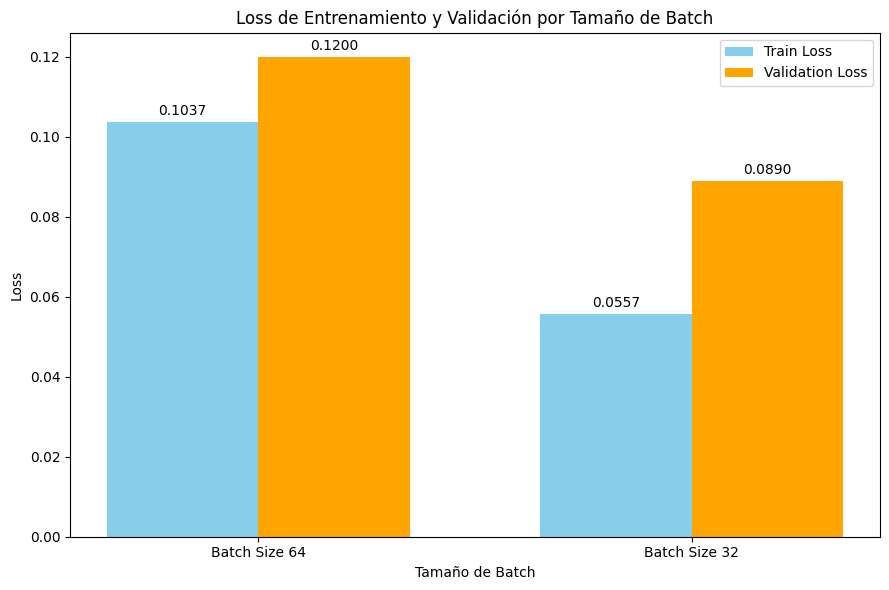

In [71]:
# Extraemos las pérdidas de entrenamiento y validación para ambos modelos
train_loss_64 = hist_sgd_epocas.history['loss'][-1]
val_loss_64 = hist_sgd_epocas.history['val_loss'][-1]

train_loss_32 = hist_sgd_batchzise.history['loss'][-1]
val_loss_32 = hist_sgd_batchzise.history['val_loss'][-1]

# Datos
labels = ['Batch Size 64', 'Batch Size 32']
train_losses = [train_loss_64, train_loss_32]
val_losses = [val_loss_64, val_loss_32]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(9, 6))

# Barras
rects1 = ax.bar(x - width/2, train_losses, width, label='Train Loss', color='skyblue')
rects2 = ax.bar(x + width/2, val_losses, width, label='Validation Loss', color='orange')

# Etiquetas y estilos
ax.set_xlabel('Tamaño de Batch')
ax.set_ylabel('Loss')
ax.set_title('Loss de Entrenamiento y Validación por Tamaño de Batch')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Función para mostrar los valores arriba de cada barra
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()

La diferencia más notable se encuentra en el loss, donde el modelo con batch size de 32 tiene un loss mucho más bajo en ambos conjuntos de datos. En entrenamiento, el modelo con batch size de 32 alcanza un loss de 0.05 frente a 0.10 en el modelo con batch size de 64. En validación, el loss es 0.08 frente a 0.12. Esto sugiere que el modelo con batch size de 32 no solo aprende de manera más efectiva durante el entrenamiento, sino que también generaliza de forma más eficiente al ser capaz de reducir el loss en ambas fases.

**Gráfico tiempo de ejecución de red con batch size 64 y red con batch size de 32**

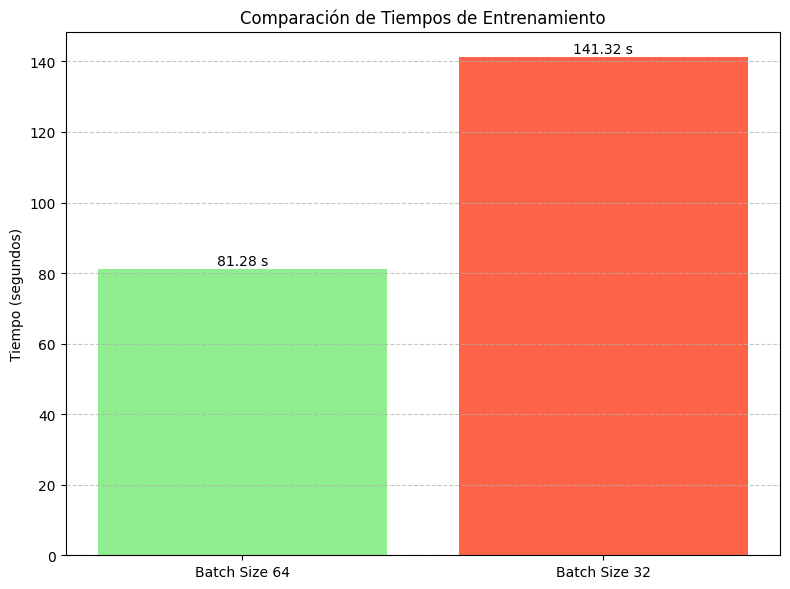

In [72]:
# Etiquetas y valores
labels = ['Batch Size 64', 'Batch Size 32']
tiempos = [time_epocas, time_batchsize]

# Crear gráfico de barras
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, tiempos, color=['lightgreen', 'tomato'])

# Agregar valores encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{yval:.2f} s', ha='center', va='bottom')

# Estética
plt.title('Comparación de Tiempos de Entrenamiento')
plt.ylabel('Tiempo (segundos)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

En este gráfico se puede observar que el modelo con un batch size de 64 completa el entrenamiento en 99 segundos, mientras que el modelo con batch size de 32 lo hace en 141 segundos.

**Conclusión**

En conclusión reducir el batch size permite actualizaciones más frecuentes de los pesos, lo que mejora la generalización y puede llevar a una mayor precisión y menor pérdida. Aunque esto implica un mayor tiempo de entrenamiento debido a más iteraciones por época, el ajuste más fino del modelo compensa el costo computacional adicional. Sin embargo, los gradientes más ruidosos en lotes pequeños pueden hacer el entrenamiento menos estable, aunque a veces ayudan a evitar mínimos locales. En general, achicar el batch size mejora el rendimiento, aunque a costa de mayor tiempo de entrenamiento.

 El modelo entrenado con un batch size de 32 demuestra ser el más adecuado, ya que logra un mejor desempeño en términos de precisión (accuracy) y pérdida (loss) tanto en los conjuntos de entrenamiento como de validación. A pesar de requerir un mayor tiempo de entrenamiento en comparación con el modelo con batch size de 64 (141 segundos frente a 99 segundos), este incremento en el costo computacional se considera aceptable frente a los beneficios obtenidos. El modelo con batch size de 32 presenta una capacidad de aprendizaje más efectiva y una mejor generalización, reflejada en un loss significativamente menor y una precisión ligeramente superior. Por tanto, se justifica priorizar la calidad del modelo y su rendimiento, aunque implique sacrificar parte del tiempo de entrenamiento.

## SGD (con cambio en el parametro de activación)

Se utilizara ELU como alternativa a ReLU porque ayuda a mejorar la precisión y la estabilidad del modelo durante el entrenamiento.

### Arquitectura de la red

In [73]:
np.random.seed(10)
tf.random.set_seed(10)


# Se crea la red feed-forward tiene 2 capas escondidas

h1 = 128
h2 = 64
h3 = 32

red_sgd_activacion = keras.Sequential(name="SGD")
red_sgd_activacion.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_activacion.add(keras.layers.Dense(h1, activation='elu', name='primera_capa'))
red_sgd_activacion.add(keras.layers.Dense(h2, activation='elu', name='segunda_capa'))
red_sgd_activacion.add(keras.layers.Dense(h3, activation='elu', name='tercera_capa'))
red_sgd_activacion.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_sgd_activacion.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'F1Score'])

### entrenamiento de la red

In [74]:
start_time_activacion = time()
hist_sgd_elu = red_sgd_activacion.fit(X_train, y_train,
        epochs=15,
        batch_size=32,
        validation_data=(X_test,y_test)
        )
end_time_activacion = time()
time_activacion = end_time_activacion - start_time_activacion
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time_activacion - start_time_activacion))

red_sgd_activacion.save('red_sgd_activacion.h5')

Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - F1Score: 0.7605 - Precision: 0.9243 - Recall: 0.5598 - accuracy: 0.7660 - loss: 0.8616 - val_F1Score: 0.9092 - val_Precision: 0.9347 - val_Recall: 0.8894 - val_accuracy: 0.9102 - val_loss: 0.3072
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - F1Score: 0.9127 - Precision: 0.9368 - Recall: 0.8936 - accuracy: 0.9136 - loss: 0.3016 - val_F1Score: 0.9229 - val_Precision: 0.9428 - val_Recall: 0.9084 - val_accuracy: 0.9238 - val_loss: 0.2542
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - F1Score: 0.9278 - Precision: 0.9464 - Recall: 0.9130 - accuracy: 0.9285 - loss: 0.2494 - val_F1Score: 0.9314 - val_Precision: 0.9485 - val_Recall: 0.9208 - val_accuracy: 0.9322 - val_loss: 0.2199
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - F1Score: 0.9378 - Precision: 0.9519 - Recall: 0.9261 - accuracy: 0.9383 - loss: 0.2142 - val_F1Score: 0.9376 - val_Precision: 0.9523 - val_Recall: 0.9293 - val_accuracy: 0.9382 - val_los

Tiempo de entrenamiento: 138.7299258709 segundos


### gráficos y conclusiones

In [133]:
# Extraer métricas de ENTRENAMIENTO de ambos modelos
accuracy_batchsize = hist_sgd_batchzise.history['accuracy'][-1] * 100
f1_score_batchsize = hist_sgd_batchzise.history['F1Score'][-1][-1]
loss_batchsize = hist_sgd_batchzise.history['loss'][-1]
precision_batchsize = hist_sgd_batchzise.history['Precision'][-1]

accuracy_elu = hist_sgd_elu.history['accuracy'][-1] * 100
f1_score_elu = hist_sgd_elu.history['F1Score'][-1][-1]
loss_elu = hist_sgd_elu.history['loss'][-1]
precision_elu = hist_sgd_elu.history['Precision'][-1]

# Extraer métricas de VALIDACIÓN de ambos modelos
val_accuracy_batchsize = hist_sgd_batchzise.history['val_accuracy'][-1] * 100
val_f1_score_batchsize = hist_sgd_batchzise.history['val_F1Score'][-1][-1]
val_loss_batchsize = hist_sgd_batchzise.history['val_loss'][-1]
val_precision_batchsize = hist_sgd_batchzise.history['val_Precision'][-1]

val_accuracy_elu = hist_sgd_elu.history['val_accuracy'][-1] * 100
val_f1_score_elu = hist_sgd_elu.history['val_F1Score'][-1][-1]
val_loss_elu = hist_sgd_elu.history['val_loss'][-1]
val_precision_elu = hist_sgd_elu.history['val_Precision'][-1]

# Índices de filas
index = [
    'Capas ocultas',
    'Optimizer',
    'Épocas',
    'Batch size',
    'Función de activación',
    'Tiempo entrenamiento aprox.',
    'Accuracy final',
    'F1-Score final',
    'Precision final',
    'Loss final'
]

# Datos Red Base (original)
red_batchsize_entrenamiento = [
    '3 (128 → 64 → 32)',
    'SGD (lr=0.01)',
    '15',
    '32',
    'Relu',
    f'{time_batchsize:.2f} segundos',
    f'{accuracy_batchsize:.2f}%',
    f'{f1_score_batchsize:.4f}',
    f'{precision_batchsize:.4f}',
    f'{loss_batchsize:.4f}'
]

red_batchsize_validacion = [
    '3 (128 → 64 → 32)',
    'SGD (lr=0.01)',
    '15',
    '32',
    'Relu',
    f'{time_batchsize:.2f} segundos',
    f'{val_accuracy_batchsize:.2f}%',
    f'{val_f1_score_batchsize:.4f}',
    f'{val_precision_batchsize:.4f}',
    f'{val_loss_batchsize:.4f}'
]

# Datos Red con Más Épocas
red_elu_entrenamiento = [
    '3 (128 → 64 → 32)',
    'SGD (lr=0.01)',
    '15',
    '32',
    'Elu',
    f'{time_activacion:.2f} segundos',
    f'{accuracy_elu:.2f}%',
    f'{f1_score_elu:.4f}',
    f'{precision_elu:.4f}',
    f'{loss_elu:.4f}'
]

red_elu_validacion = [
    '3 (128 → 64 → 32)',
    'SGD (lr=0.01)',
    '15',
    '32',
    'Elu',
    f'{time_activacion:.2f} segundos',
    f'{val_accuracy_elu:.2f}%',
    f'{val_f1_score_elu:.4f}',
    f'{val_precision_elu:.4f}',
    f'{val_loss_elu:.4f}'
]

# Simular combinación de celdas para las primeras 4 filas (hasta Batch size incluido)
red_batchsize_entrenamiento_mod = red_batchsize_entrenamiento.copy()
red_batchsize_validacion_mod = red_batchsize_validacion.copy()
red_elu_entrenamiento_mod = red_elu_entrenamiento.copy()
red_elu_validacion_mod = red_elu_validacion.copy()

for i in range(5):  # 'Capas ocultas', 'Optimizer', 'Épocas', 'Batch size'
    red_batchsize_validacion_mod[i] = ''  # Dejar vacío para simular celda combinada
    red_elu_validacion_mod[i] = ''

# Crear MultiIndex para las columnas
columnas = pd.MultiIndex.from_product(
    [['Red con Relu', 'Red con Elu'], ['Entrenamiento', 'Validación']],
    names=['Modelo', 'Tipo']
)

# Crear DataFrame con los datos
data = list(zip(
    red_batchsize_entrenamiento_mod, red_batchsize_validacion_mod,
    red_elu_entrenamiento_mod, red_elu_validacion_mod
))

comparacion_activacion_df = pd.DataFrame(data, index=index, columns=columnas)

# Mostrar la tabla
display(comparacion_activacion_df)

Modelo                            Red con Relu                   \
Tipo                             Entrenamiento       Validación   
Capas ocultas                3 (128 → 64 → 32)                    
Optimizer                        SGD (lr=0.01)                    
Épocas                                      15                    
Batch size                                  32                    
Función de activación                     Relu                    
Tiempo entrenamiento aprox.    141.32 segundos  141.32 segundos   
Accuracy final                          98.41%           97.34%   
F1-Score final                          0.9766           0.9638   
Precision final                         0.9872           0.9775   
Loss final                              0.0557           0.0890   

Modelo                             Red con Elu                   
Tipo                             Entrenamiento       Validación  
Capas ocultas                3 (128 → 64 → 32)                   
Optimizer                        SGD (lr=0.01)                   
Épocas                                      15                   
Batch size                                  32                   
Función de activación                      Elu                   
Tiempo entrenamiento aprox.    138.73 segundos  138.73 segundos  
Accuracy final                          97.54%           96.85%  
F1-Score final                          0.9665           0.9573  
Precision final                         0.9800           0.9728  
Loss final                              0.0841           0.1058

La siguiente tabla resume las diferencias observadas entre dos redes neuronales que comparten la misma arquitectura, diferenciándose únicamente por la función de activación utilizada. Con el fin de complementar este análisis comparativo, se incorporan gráficos de barras que representan los valores de accuracy y loss tanto en entrenamiento como en validación, lo cual permite una visualización más clara y una interpretación más precisa del desempeño de cada modelo.

**Gráficos de comparación de accuracy con relu y elu**

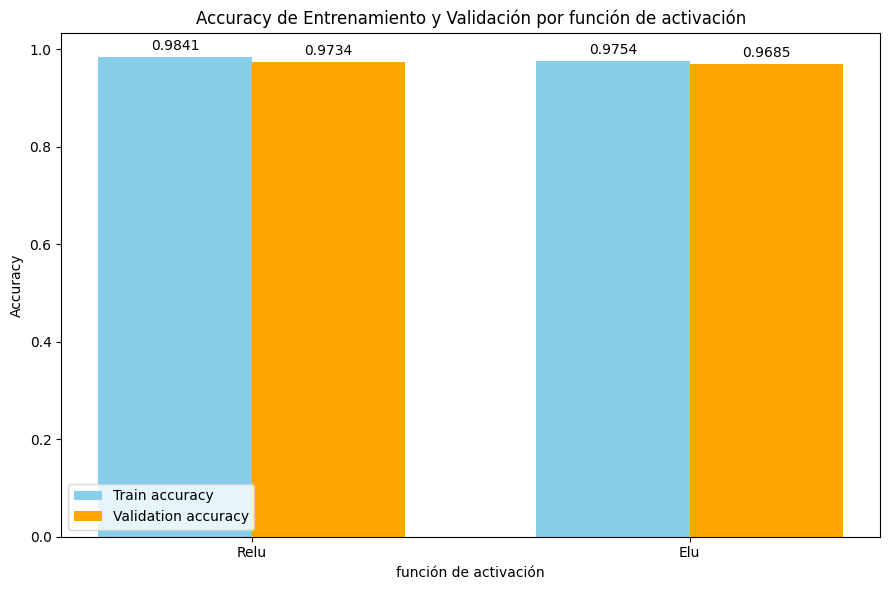

In [78]:
# Extraemos las pérdidas de entrenamiento y validación para ambos modelos
train_loss_batchsize = hist_sgd_batchzise.history['accuracy'][-1]
val_loss_batchsize = hist_sgd_batchzise.history['val_accuracy'][-1]

train_loss_elu = hist_sgd_elu.history['accuracy'][-1]
val_loss_elu = hist_sgd_elu.history['val_accuracy'][-1]

# Datos
labels = ['Relu', 'Elu']
train_losses = [train_loss_batchsize, train_loss_elu]
val_losses = [val_loss_batchsize, val_loss_elu]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(9, 6))

# Barras
rects1 = ax.bar(x - width/2, train_losses, width, label='Train accuracy', color='skyblue')
rects2 = ax.bar(x + width/2, val_losses, width, label='Validation accuracy', color='orange')

# Etiquetas y estilos
ax.set_xlabel('función de activación')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy de Entrenamiento y Validación por función de activación')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Función para mostrar los valores arriba de cada barra
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()

Al analizar los resultados obtenidos, se observa que la red con ReLU muestra un accuracy superior en la fase de entrenamiento, alcanzando un 98% frente al 97% logrado por la red con ELU. Esto sugiere que ReLU permite un mejor ajuste sobre los datos de entrenamiento. Sin embargo, en la fase de validación, la diferencia entre ambas redes es más pequeña, con ReLU obteniendo un 97% de accuracy y ELU alcanzando un 96%. Esta pequeña variación indica que, aunque ReLU tiene un ligero mejor desempeño en entrenamiento, ambas funciones de activación presentan una capacidad de generalización bastante similar. En conclusión, tanto ReLU como ELU son adecuadas para este caso de estudio, pero ReLU tiene una ligera ventaja en términos de rendimiento tanto en entrenamiento como en validación.

**Gráficos de comparación de Loss con relu y elu**

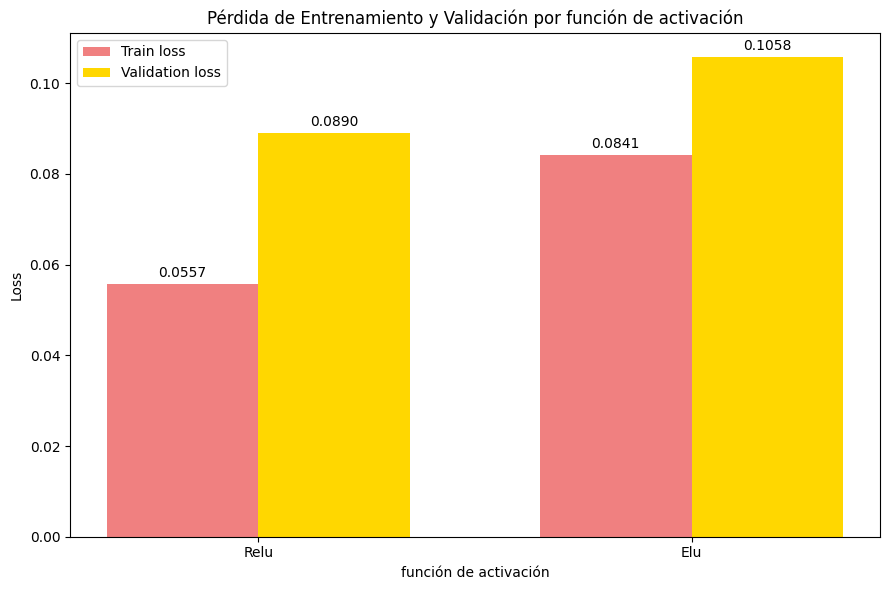

In [79]:
# Extraemos las pérdidas de entrenamiento y validación para ambos modelos
train_loss_batchsize = hist_sgd_batchzise.history['loss'][-1]
val_loss_batchsize = hist_sgd_batchzise.history['val_loss'][-1]

train_loss_elu = hist_sgd_elu.history['loss'][-1]
val_loss_elu = hist_sgd_elu.history['val_loss'][-1]

# Datos
labels = ['Relu', 'Elu']
train_losses = [train_loss_batchsize, train_loss_elu]
val_losses = [val_loss_batchsize, val_loss_elu]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(9, 6))

# Barras
rects1 = ax.bar(x - width/2, train_losses, width, label='Train loss', color='lightcoral')
rects2 = ax.bar(x + width/2, val_losses, width, label='Validation loss', color='gold')

# Etiquetas y estilos
ax.set_xlabel('función de activación')
ax.set_ylabel('Loss')
ax.set_title('Pérdida de Entrenamiento y Validación por función de activación')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Función para mostrar los valores arriba de cada barra
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()

Al comparar las funciones de activación ReLU y ELU en términos de la función de pérdida (loss), se observa que la red con ReLU alcanza una menor pérdida tanto en entrenamiento 0.05 como en validación 0.08, en comparación con la red con ELU, que presenta un loss de 0.08 en entrenamiento y 0.10 en validación.

Estos resultados indican que la red con ReLU logró un ajuste más preciso durante el proceso de entrenamiento y mantuvo un mejor desempeño al enfrentarse a datos no vistos. La diferencia, aunque no drástica, sugiere que ReLU permitió una convergencia más efectiva del modelo. Además, la menor pérdida en validación asociada a ReLU puede interpretarse como una mejor capacidad de generalización frente a la alternativa con ELU.

**Conclusión**

Al no observarse diferencias significativas en los valores de accuracy entre ambas redes, se considera que la mejor elección de modelo debe basarse en la métrica de pérdida (loss). En este contexto, la red que utiliza la función de activación ReLU presenta un menor loss tanto en el conjunto de entrenamiento como en el de validación, lo que indica un mejor desempeño en términos de ajuste y generalización. Por lo tanto, bajo estas condiciones experimentales, se concluye que la función de activación ReLU es más eficiente que ELU para esta arquitectura específica.

## SGD (con drop out)

### Arquitectura de la red

In [88]:
np.random.seed(10)
tf.random.set_seed(10)


# Se crea la red feed-forward tiene 2 capas escondidas

h1 = 128
h2 = 64
h3 = 32

red_sgd_dropout = keras.Sequential(name="SGD")
red_sgd_dropout.add(keras.layers.Input(shape=(N,), name='entrada'))
red_sgd_dropout.add(keras.layers.Dense(h1, activation='relu', name='primera_capa'))
red_sgd_dropout.add(keras.layers.Dropout(0.15))
red_sgd_dropout.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_sgd_dropout.add(keras.layers.Dropout(0.15))
red_sgd_dropout.add(keras.layers.Dense(h3, activation='relu', name='tercera_capa'))
red_sgd_dropout.add(keras.layers.Dropout(0.15))
red_sgd_dropout.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_sgd_dropout.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'F1Score'])

### Entrenamiento de la red

In [89]:
start_time_dropout = time()
hist_sgd_dropout = red_sgd_dropout.fit(X_train, y_train,
        epochs=15,
        batch_size=32,
        validation_data=(X_test,y_test)
        )
end_time_dropout = time()
time_dropout = end_time_dropout - start_time_dropout
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time_dropout - start_time_dropout))

red_sgd_dropout.save('red_sgd_dropout.h5')

Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - F1Score: 0.5201 - Precision: 0.8270 - Recall: 0.3062 - accuracy: 0.5349 - loss: 1.3692 - val_F1Score: 0.9010 - val_Precision: 0.9367 - val_Recall: 0.8701 - val_accuracy: 0.9027 - val_loss: 0.3447
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - F1Score: 0.8552 - Precision: 0.9028 - Recall: 0.8086 - accuracy: 0.8573 - loss: 0.4747 - val_F1Score: 0.9265 - val_Precision: 0.9461 - val_Recall: 0.9108 - val_accuracy: 0.9277 - val_loss: 0.2463
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - F1Score: 0.8944 - Precision: 0.9262 - Recall: 0.8658 - accuracy: 0.8958 - loss: 0.3566 - val_F1Score: 0.9386 - val_Precision: 0.9553 - val_Recall: 0.9261 - val_accuracy: 0.9394 - val_loss: 0.2010
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - F1Score: 0.9157 - Precision: 0.9389 - Recall: 0.8925 - accuracy: 0.9166 - loss: 0.2927 - val_F1Score: 0.9458 - val_Precision: 0.9605 - val_Recall: 0.9364 - val_accuracy: 0.9465 - val_loss:

Tiempo de entrenamiento: 142.5437867641 segundos


### Gráficos y conclusiones

In [90]:
# Extraer métricas de ENTRENAMIENTO de ambos modelos
accuracy_batchsize = hist_sgd_batchzise.history['accuracy'][-1] * 100
f1_score_batchsize = hist_sgd_batchzise.history['F1Score'][-1][-1]
loss_batchsize = hist_sgd_batchzise.history['loss'][-1]
precision_batchsize = hist_sgd_batchzise.history['Precision'][-1]

accuracy_dropout = hist_sgd_dropout.history['accuracy'][-1] * 100
f1_score_dropout = hist_sgd_dropout.history['F1Score'][-1][-1]
loss_dropout = hist_sgd_dropout.history['loss'][-1]
precision_dropout = hist_sgd_dropout.history['Precision'][-1]

# Extraer métricas de VALIDACIÓN de ambos modelos
val_accuracy_batchsize = hist_sgd_batchzise.history['val_accuracy'][-1] * 100
val_f1_score_batchsize = hist_sgd_batchzise.history['val_F1Score'][-1][-1]
val_loss_batchsize = hist_sgd_batchzise.history['val_loss'][-1]
val_precision_batchsize = hist_sgd_batchzise.history['val_Precision'][-1]

val_accuracy_dropout = hist_sgd_dropout.history['val_accuracy'][-1] * 100
val_f1_score_dropout = hist_sgd_dropout.history['val_F1Score'][-1][-1]
val_loss_dropout = hist_sgd_dropout.history['val_loss'][-1]
val_precision_dropout = hist_sgd_dropout.history['val_Precision'][-1]

# Índices de filas
index = [
    'Capas ocultas',
    'Optimizer',
    'Épocas',
    'Batch size',
    'Función de activación',
    'Tiempo entrenamiento aprox.',
    'Accuracy final',
    'F1-Score final',
    'Precision final',
    'Loss final'
]

# Datos Red Base (original)
red_batchsize_entrenamiento = [
    '3 (128 → 64 → 32)',
    'SGD (lr=0.01)',
    '15',
    '32',
    'Relu',
    f'{time_batchsize:.2f} segundos',
    f'{accuracy_batchsize:.2f}%',
    f'{f1_score_batchsize:.4f}',
    f'{precision_batchsize:.4f}',
    f'{loss_batchsize:.4f}'
]

red_batchsize_validacion = [
    '3 (128 → 64 → 32)',
    'SGD (lr=0.01)',
    '15',
    '32',
    'Relu',
    f'{time_batchsize:.2f} segundos',
    f'{val_accuracy_batchsize:.2f}%',
    f'{val_f1_score_batchsize:.4f}',
    f'{val_precision_batchsize:.4f}',
    f'{val_loss_batchsize:.4f}'
]

# Datos Red con Más Épocas
red_dropout_entrenamiento = [
    '3 (128 → 64 → 32)',
    'SGD (lr=0.01)',
    '15',
    '32',
    'Relu',
    f'{time_dropout:.2f} segundos',
    f'{accuracy_dropout:.2f}%',
    f'{f1_score_dropout:.4f}',
    f'{precision_dropout:.4f}',
    f'{loss_dropout:.4f}'
]

red_dropout_validacion = [
    '3 (128 → 64 → 32)',
    'SGD (lr=0.01)',
    '15',
    '32',
    'Relu',
    f'{time_dropout:.2f} segundos',
    f'{val_accuracy_dropout:.2f}%',
    f'{val_f1_score_dropout:.4f}',
    f'{val_precision_dropout:.4f}',
    f'{val_loss_dropout:.4f}'
]

# Simular combinación de celdas para las primeras 4 filas (hasta Batch size incluido)
red_batchsize_entrenamiento_mod = red_batchsize_entrenamiento.copy()
red_batchsize_validacion_mod = red_batchsize_validacion.copy()
red_dropout_entrenamiento_mod = red_dropout_entrenamiento.copy()
red_dropout_validacion_mod = red_dropout_validacion.copy()

for i in range(6):  # 'Capas ocultas', 'Optimizer', 'Épocas', 'Batch size'
    red_batchsize_validacion_mod[i] = ''  # Dejar vacío para simular celda combinada
    red_dropout_validacion_mod[i] = ''

# Crear MultiIndex para las columnas
columnas = pd.MultiIndex.from_product(
    [['Red sin Dropout', 'Red con Dropout'], ['Entrenamiento', 'Validación']],
    names=['Modelo', 'Tipo']
)

# Crear DataFrame con los datos
data = list(zip(
    red_batchsize_entrenamiento_mod, red_batchsize_validacion_mod,
    red_dropout_entrenamiento_mod, red_dropout_validacion_mod
))

comparacion_activacion_df = pd.DataFrame(data, index=index, columns=columnas)

# Mostrar la tabla
display(comparacion_activacion_df)

Modelo                         Red sin Dropout               Red con Dropout  \
Tipo                             Entrenamiento Validación      Entrenamiento   
Capas ocultas                3 (128 → 64 → 32)             3 (128 → 64 → 32)   
Optimizer                        SGD (lr=0.01)                 SGD (lr=0.01)   
Épocas                                      15                            15   
Batch size                                  32                            32   
Función de activación                     Relu                          Relu   
Tiempo entrenamiento aprox.    141.32 segundos               142.54 segundos   
Accuracy final                          98.41%     97.34%             96.40%   
F1-Score final                          0.9766     0.9638             0.9489   
Precision final                         0.9872     0.9775             0.9726   
Loss final                              0.0557     0.0890             0.1226   

Modelo                                  
Tipo                        Validación  
Capas ocultas                           
Optimizer                               
Épocas                                  
Batch size                              
Función de activación                   
Tiempo entrenamiento aprox.             
Accuracy final                  97.37%  
F1-Score final                  0.9664  
Precision final                 0.9787  
Loss final                      0.0889

Con el objetivo de analizar el impacto del uso de la técnica de dropout en redes neuronales, se comparan dos modelos con idéntica arquitectura y configuración de entrenamiento, diferenciándose únicamente en la aplicación de dicha técnica de regularización. Para facilitar una interpretación más clara de los resultados, se presentan gráficos de barras que ilustran las métricas de accuracy y loss obtenidas en los conjuntos de entrenamiento y validación. Esta representación visual permite evaluar de manera más precisa el comportamiento general de cada modelo, así como su capacidad de generalización bajo las condiciones experimentales establecidas.

**Graficos de linea para las diferencias entre accuracy y loss entre la red sin drop out y la red con drop out**

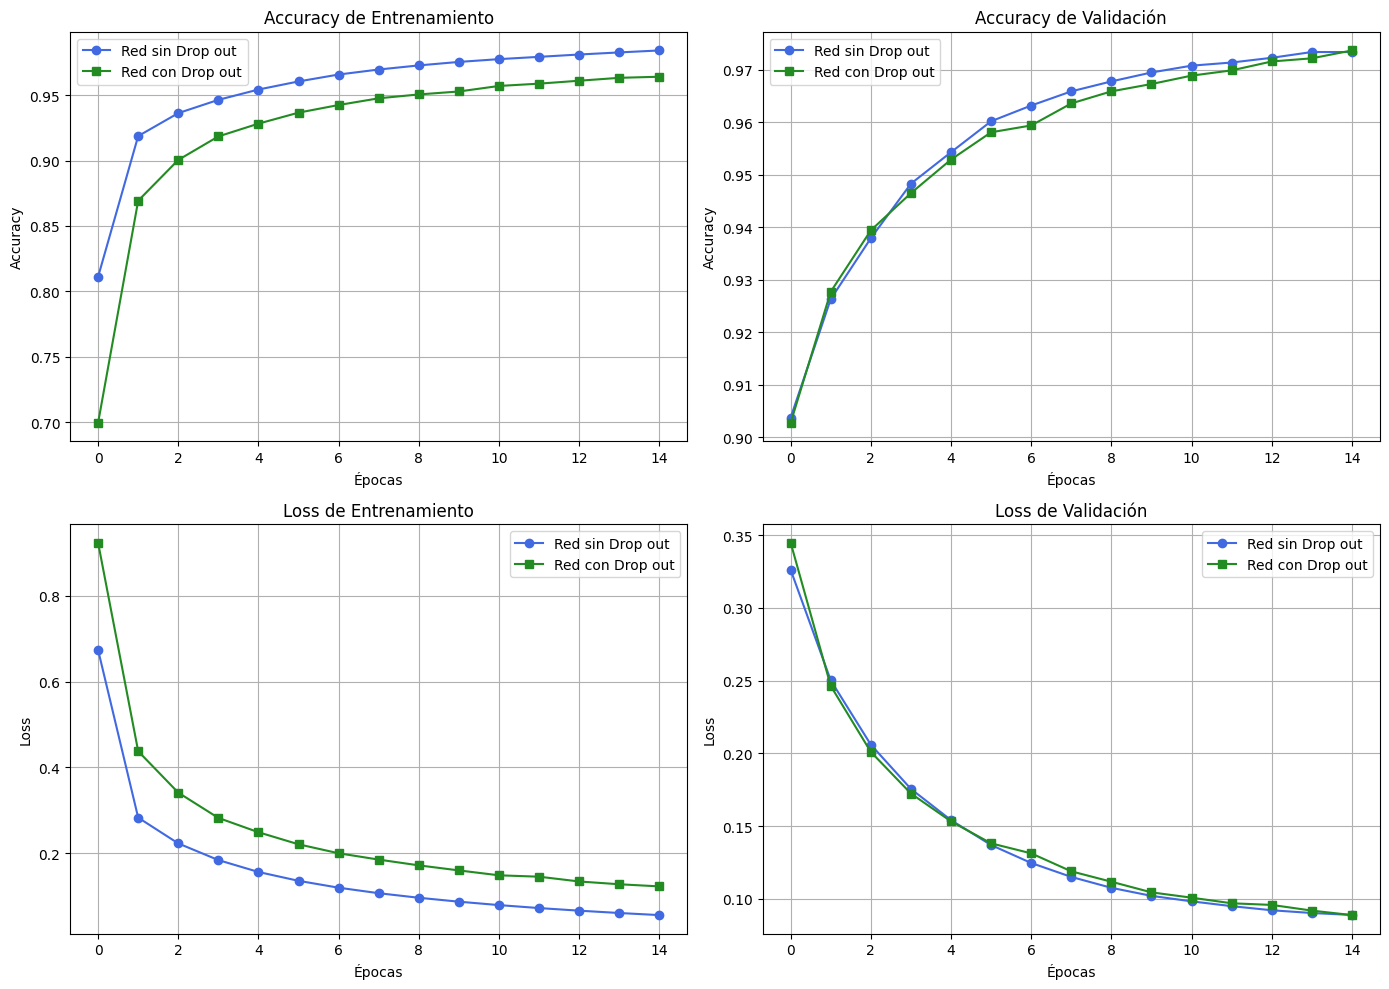

In [91]:
# Extraer métricas
acc_batchsize_entrenamiento = hist_sgd_batchzise.history['accuracy']
acc_dropout_entrenamiento = hist_sgd_dropout.history['accuracy']

val_acc_batchsize = hist_sgd_batchzise.history['val_accuracy']
val_acc_dropout = hist_sgd_dropout.history['val_accuracy']

loss_batchsize_entrenamiento = hist_sgd_batchzise.history['loss']
loss_dropout_entrenamiento = hist_sgd_dropout.history['loss']

loss_batchsize_validacion = hist_sgd_batchzise.history['val_loss']
loss_dropout_validacion = hist_sgd_dropout.history['val_loss']

# Crear figura y ejes en un grid 2x2
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy de entrenamiento
axs[0, 0].plot(acc_batchsize_entrenamiento, label='Red sin Drop out', marker='o', color='royalblue')
axs[0, 0].plot(acc_dropout_entrenamiento, label='Red con Drop out', marker='s', color='forestgreen')
axs[0, 0].set_title('Accuracy de Entrenamiento')
axs[0, 0].set_xlabel('Épocas')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Accuracy de validación
axs[0, 1].plot(val_acc_batchsize, label='Red sin Drop out', marker='o', color='royalblue')
axs[0, 1].plot(val_acc_dropout, label='Red con Drop out', marker='s', color='forestgreen')
axs[0, 1].set_title('Accuracy de Validación')
axs[0, 1].set_xlabel('Épocas')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Loss de entrenamiento
axs[1, 0].plot(loss_batchsize_entrenamiento, label='Red sin Drop out', marker='o', color='royalblue')
axs[1, 0].plot(loss_dropout_entrenamiento, label='Red con Drop out', marker='s', color='forestgreen')
axs[1, 0].set_title('Loss de Entrenamiento')
axs[1, 0].set_xlabel('Épocas')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Loss de validación
axs[1, 1].plot(loss_batchsize_validacion, label='Red sin Drop out', marker='o', color='royalblue')
axs[1, 1].plot(loss_dropout_validacion, label='Red con Drop out', marker='s', color='forestgreen')
axs[1, 1].set_title('Loss de Validación')
axs[1, 1].set_xlabel('Épocas')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

Del análisis comparativo entre la red neuronal con y sin la técnica de regularización Dropout, se observa que la red sin Dropout alcanza un mayor accuracy durante el entrenamiento (98%) y una precisión en validación de 97%. Si bien existe una ligera diferencia, esta no representa necesariamente una señal clara de sobreajuste, ya que la brecha entre ambas métricas es mínima y se encuentra dentro de un rango aceptable de variación. Por otro lado, la red con Dropout, si bien obtiene un accuracy de entrenamiento ligeramente inferior (96%), logra un mejor rendimiento en validación (97%) y presenta una menor pérdida (loss) en el conjunto de validacion, lo cual evidencia una mayor capacidad de generalización.

La red con Dropout se considera más adecuada, ya que, a pesar de obtener un accuracy ligeramente inferior en entrenamiento, logra mejores resultados en validación y una menor pérdida, lo que indica una mayor capacidad de generalización. Esta estabilidad en el rendimiento frente a datos no vistos refuerza la efectividad del Dropout como técnica de regularización para prevenir el sobreajuste.



**Conclusion final de las pruebas al modelo SGD**

Durante el proceso experimental, se inició con un modelo base que utilizaba el optimizador SGD, función de activación ReLU, una tasa de aprendizaje de 0.01, cinco épocas, un batch size de 64 y sin la implementación de Dropout. A partir de esta configuración inicial, se llevaron a cabo múltiples ajustes orientados a optimizar el desempeño del modelo.

Entre las modificaciones realizadas, se incrementó el número de épocas a 15, se redujo el batch size a 32 y se incorporó una tasa de Dropout del 15% en todas las capas ocultas. Si bien se mantuvo la función de activación ReLU como constante en la mayoría de las pruebas, se exploró brevemente el uso de la función ELU. Sin embargo, dicha variante resultó en una disminución de la precisión del modelo y un aumento en la función de pérdida, lo que justificó descartar su uso en etapas posteriores.

Con base en los resultados obtenidos, se concluye que la configuración final, que incluye Dropout, mayor cantidad de épocas y un batch size ajustado, presenta el mejor rendimiento en términos de precisión y capacidad de generalización. Esta última versión es la más eficiente en comparación con las pruebas anteriores y se posiciona como la mejor opción para este modelo con optimizador SGD.

## Adam (Adaptive Moment Estimation)

En la segunda experimentación se decidió utilizar el optimizador Adam (Adaptive Moment Estimation) debido a sus ventajas en tareas de clasificación y su capacidad para adaptarse dinámicamente durante el entrenamiento. A diferencia de SGD, Adam ajusta automáticamente la tasa de aprendizaje para cada parámetro, combinando los beneficios de los métodos Momentum y RMSprop. Esto permite que el entrenamiento sea más rápido y estable, especialmente en redes con varias capas o cuando se requiere mayor precisión en la convergencia.

Adam es ampliamente utilizado en tareas con conjuntos de datos como MNIST, ya que tiende a encontrar buenos resultados sin necesidad de una gran cantidad de ajustes manuales en los hiperparámetros. Por esta razón, se considera una excelente opción para comparar con el rendimiento obtenido en la primera experimentación usando SGD.

Se utilizará categorical_crossentropy como función de pérdida ya que se trata de un problema de clasificación multiclase. Además, las etiquetas del conjunto de datos ya se encuentran codificadas en formato one-hot, lo que la convierte en la opción más adecuada para esta tarea.

Se utiliza ReLU como función de activación porque es computacionalmente eficiente y ayuda a que las redes neuronales profundas aprendan más rápido.

Para la evaluación del rendimiento del modelo, se consideraron principalmente las métricas de accuracy y loss tanto en los conjuntos de entrenamiento como de validación. Estas métricas permitieron comparar objetivamente los modelos generados y seleccionar el que ofreciera un mejor equilibrio entre precisión y generalización. No se utilizaron métricas como F1-score y recall ya que el conjunto de datos MNIST está balanceado y no presenta clases desbalanceadas, por lo que la accuracy resulta ser una métrica suficiente y representativa del rendimiento general del modelo.

**Arquitectura de la red base**
* Optimizador: Adam (Adaptive Moment Estimation)
* Capas ocultas: 3
* Primera capa: 128 neuronas
* Segunda capa: 64 neuronas
* Tercera capa: 32 neuronas
* Función de activacion: RELU para capas ocultas
* Función de activación: SOFTMAX para la capa de salida
* Learning rate: 0.001
* Loss: categorical_crossentropy
* Metricas: accuracy, Precision, Recall, F1Score

**Entrenamiento de la reed base**
* Epocas: 5
* Batch size: 64

### Arquitectura de la red

In [92]:
# Setea los seed para números random

np.random.seed(10)
tf.random.set_seed(10)


# Se crea la red feed-forward tiene 3 capas escondidas

h1 = 128
h2 = 64
h3 = 32

red_adam = keras.Sequential(name="ADAM")
red_adam.add(keras.layers.Input(shape=(N,), name='entrada'))
red_adam.add(keras.layers.Dense(h1, activation='relu', name='primera_capa'))
red_adam.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_adam.add(keras.layers.Dense(h3, activation='relu', name='tercera_capa'))
red_adam.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_adam.summary()

red_adam.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'F1Score'])

Model: "ADAM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ primera_capa (Dense)            │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ segunda_capa (Dense)            │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tercera_capa (Dense)            │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_de_salida (Dense)          │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,146 (434.16 KB)

 Trainable params: 111,146 (434.16 KB)

 Non-trainable params: 0 (0.00 B)

Cantidad de parametros de cada capa

* Para la primera capa: 100.480 = 28 x 28 x 128 +128
* Para la segunda capa: 8.256 = 128 x 64 + 64
* Para la tercera capa: 2080 = 64 x 32 + 32
* Para la capa de salida 330 = 32 x 10 + 10

### Entrenamiento de la red

In [93]:
start_time_adam = time()
hist_adam = red_adam.fit(X_train, y_train,
        epochs=5,
        batch_size=64,
        validation_data=(X_test,y_test)
        )
end_time_adam = time()
time_base_adam = end_time_adam - start_time_adam
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time_adam - start_time_adam))

red_adam.save('red_adam.h5')

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - F1Score: 0.8360 - Precision: 0.9257 - Recall: 0.7523 - accuracy: 0.8404 - loss: 0.5466 - val_F1Score: 0.9559 - val_Precision: 0.9634 - val_Recall: 0.9488 - val_accuracy: 0.9562 - val_loss: 0.1413
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - F1Score: 0.9602 - Precision: 0.9681 - Recall: 0.9544 - accuracy: 0.9604 - loss: 0.1297 - val_F1Score: 0.9695 - val_Precision: 0.9742 - val_Recall: 0.9654 - val_accuracy: 0.9697 - val_loss: 0.1019
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - F1Score: 0.9743 - Precision: 0.9779 - Recall: 0.9705 - accuracy: 0.9744 - loss: 0.0860 - val_F1Score: 0.9739 - val_Precision: 0.9773 - val_Recall: 0.9714 - val_accuracy: 0.9741 - val_loss: 0.0895
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - F1Score: 0.9809 - Precision: 0.9839 - Recall: 0.9789 - accuracy: 0.9811 - loss: 0.0625 - val_F1Score: 0.9746 - val_Precision: 0.9781 - val_Recall: 0.9721 - val_accuracy: 0.9749 - val_loss: 0.0870


Tiempo de entrenamiento: 48.9032785892 segundos


### Gráficos y conclusiones

G**ráfico de porcentaje de acierto**

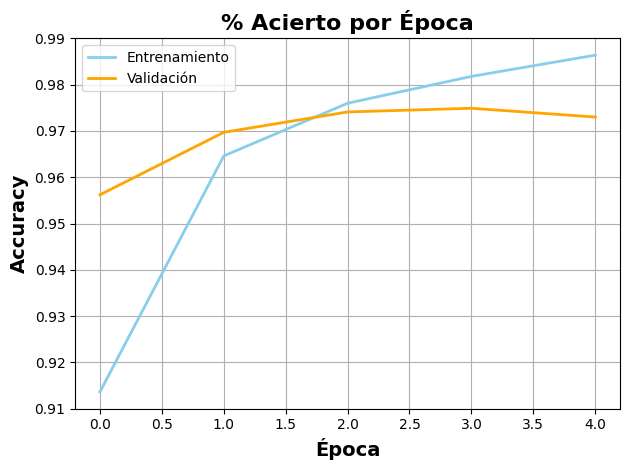

In [94]:
# Gráfica el % de acierto para entrenamiento y validación por época
plt.plot(hist_adam.history['accuracy'], label='Entrenamiento', color='skyblue', linewidth=2)
plt.plot(hist_adam.history['val_accuracy'], label='Validación', color='orange', linewidth=2)

plt.title('% Acierto por Época', fontsize=16, fontweight="bold")
plt.xlabel('Época', fontsize=14, fontweight="bold")
plt.ylabel('Accuracy', fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Gráfico de porcentaje de perdida**

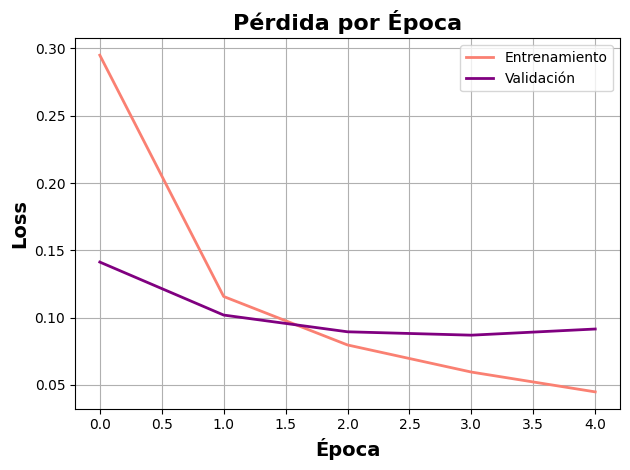

In [95]:
# Gráfica la pérdida (loss) en entrenamiento y validación por época
plt.plot(hist_adam.history['loss'], label='Entrenamiento', color='salmon', linewidth=2)
plt.plot(hist_adam.history['val_loss'], label='Validación', color='purple', linewidth=2)

plt.title('Pérdida por Época', fontsize=16, fontweight="bold")
plt.xlabel('Época', fontsize=14, fontweight="bold")
plt.ylabel('Loss', fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Conclusión**

El modelo entrenado con Adam y una tasa de aprendizaje de 0.001 aprendió de manera eficiente, logrando una alta precisión tanto en el conjunto de entrenamiento como de validación. La diferencia entre ambas precisiones es pequeña, lo que sugiere que el modelo no está sobreajustando.

## Adam (Adaptive Moment Estimation) con más capas

### Arquitectura de la red

In [100]:
# Setea los seed para números random

np.random.seed(10)
tf.random.set_seed(10)


# Se crea la red feed-forward tiene 7 capas escondidas

h1 = 128
h2 = 64
h3 = 32

red_adam_mascapas = keras.Sequential(name="ADAM")
red_adam_mascapas.add(keras.layers.Input(shape=(N,), name='entrada'))
red_adam_mascapas.add(keras.layers.Dense(h1, activation='relu', name='primera_capa'))
red_adam_mascapas.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_adam_mascapas.add(keras.layers.Dense(h3, activation='relu', name='tercera_capa'))
red_adam_mascapas.add(keras.layers.Dense(h3, activation='relu', name='cuarta_capa'))
red_adam_mascapas.add(keras.layers.Dense(h3, activation='relu', name='quinta_capa'))
red_adam_mascapas.add(keras.layers.Dense(h3, activation='relu', name='sexta_capa'))
red_adam_mascapas.add(keras.layers.Dense(h3, activation='relu', name='septima_capa'))
red_adam_mascapas.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_adam_mascapas.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'F1Score'])

### Entrenamiento de la red

In [101]:
start_time_mascapas_adam = time()
hist_adam_mascapas = red_adam_mascapas.fit(X_train, y_train,
        epochs=5,
        batch_size=64,
        validation_data=(X_test,y_test)
        )
end_time_mascapas_adam = time()
time_mascapas_adam = end_time_mascapas_adam - start_time_mascapas_adam
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time_mascapas_adam - start_time_mascapas_adam))

red_adam_mascapas.save('red_adam_mascapas.h5')

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - F1Score: 0.7653 - Precision: 0.8964 - Recall: 0.6909 - accuracy: 0.7667 - loss: 0.6998 - val_F1Score: 0.9523 - val_Precision: 0.9606 - val_Recall: 0.9471 - val_accuracy: 0.9525 - val_loss: 0.1580
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - F1Score: 0.9585 - Precision: 0.9663 - Recall: 0.9527 - accuracy: 0.9588 - loss: 0.1417 - val_F1Score: 0.9647 - val_Precision: 0.9713 - val_Recall: 0.9615 - val_accuracy: 0.9649 - val_loss: 0.1162
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - F1Score: 0.9706 - Precision: 0.9755 - Recall: 0.9664 - accuracy: 0.9708 - loss: 0.1024 - val_F1Score: 0.9664 - val_Precision: 0.9697 - val_Recall: 0.9637 - val_accuracy: 0.9665 - val_loss: 0.1169
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - F1Score: 0.9777 - Precision: 0.9805 - Recall: 0.9754 - accuracy: 0.9778 - loss: 0.0773 - val_F1Score: 0.9733 - val_Precision: 0.9778 - val_Recall: 0.9717 - val_accuracy: 0.9735 - val_loss: 0.0922
Ep

Tiempo de entrenamiento: 44.1439275742 segundos


### Gráficos y colclusiones

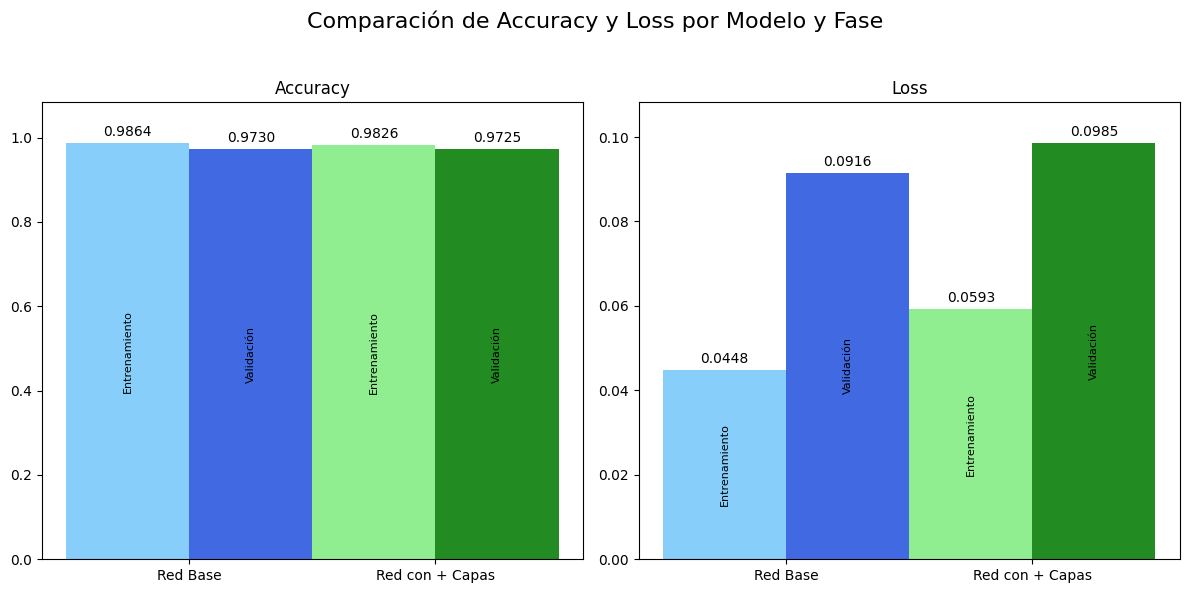

In [102]:
# Extraer métricas de ENTRENAMIENTO de ambos modelos
accuracy_adam_base = hist_adam.history['accuracy'][-1] * 100
loss_adam_base = hist_adam.history['loss'][-1]

accuracy_adam_mascapas = hist_adam_mascapas.history['accuracy'][-1] * 100
loss_adam_mascapas = hist_adam_mascapas.history['loss'][-1]

# Extraer métricas de VALIDACIÓN de ambos modelos
val_accuracy_adam_base = hist_adam.history['val_accuracy'][-1] * 100
val_loss_adam_base = hist_adam.history['val_loss'][-1]

val_accuracy_adam_mascapas = hist_adam_mascapas.history['val_accuracy'][-1] * 100
val_loss_adam_mascapas = hist_adam_mascapas.history['val_loss'][-1]

# Datos de entrenamiento y validación solo para Accuracy y Loss
base_modelo_entrenamiento = [accuracy_adam_base / 100, loss_adam_base]
modelo_con_capas_entrenamiento = [accuracy_adam_mascapas / 100, loss_adam_mascapas]

base_modelo_validacion = [val_accuracy_adam_base / 100, val_loss_adam_base]
modelo_con_capas_validacion = [val_accuracy_adam_mascapas / 100, val_loss_adam_mascapas]

# Ancho de cada barra
bar_width = 0.2

# Función para agregar etiquetas
def agregar_etiquetas(ax, bars, fase):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
        ax.text(bar.get_x() + bar.get_width() / 2, height / 2,
                f'{fase}', ha='center', va='center',
                rotation=90, fontsize=8, color='black')

# Crear figura y ejes
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Comparación de Accuracy y Loss por Modelo y Fase', fontsize=16)

# Métricas por subplot
titulos = ['Accuracy', 'Loss']
indices = [0, 1]

for i, idx in enumerate(indices):
    ax = axs[i]
    ax.set_title(titulos[i])

    # Valores
    valores = [
        base_modelo_entrenamiento[idx],
        base_modelo_validacion[idx],
        modelo_con_capas_entrenamiento[idx],
        modelo_con_capas_validacion[idx]
    ]

    # Posiciones sin separación entre grupos
    pos = np.arange(4) * bar_width

    colores = ['lightskyblue', 'royalblue', 'lightgreen', 'forestgreen']
    etiquetas_fase = ['Entrenamiento', 'Validación', 'Entrenamiento', 'Validación']
    etiquetas_xtick = ['Red Base', 'Red con + Capas']
    tick_pos = [pos[0] + bar_width/2, pos[2] + bar_width/2]

    for j in range(4):
        bar = ax.bar(pos[j], valores[j], width=bar_width, color=colores[j])
        agregar_etiquetas(ax, bar, etiquetas_fase[j])

    ax.set_xticks(tick_pos)
    ax.set_xticklabels(etiquetas_xtick)
    ax.set_ylim(0, max(valores) * 1.1)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Al analizar los gráficos de desempeño del modelo durante el entrenamiento, se observa que la métrica de accuracy presenta valores muy similares tanto en los conjuntos de entrenamiento como de validación, lo que indica un comportamiento consistente y sin señales evidentes de sobreajuste en ambas configuraciones evaluadas. Dado que esta métrica no muestra diferencias significativas entre los modelos, se opta por utilizar la función de pérdida (loss) como criterio principal para determinar cuál modelo tiene un mejor rendimiento general.

En este contexto, se evidencia que el modelo basado en Adam con arquitectura simple (Adam base) alcanza valores de pérdida menores en comparación con el modelo que incorpora una arquitectura más profunda (Adam con más capas). Por lo tanto, se concluye que el modelo Adam base resulta más eficiente y adecuado para el problema en cuestión, al lograr minimizar mejor el error durante el proceso de entrenamiento.

## Adam (Adaptive Moment Estimation) con más epocas

### Arquitectura de la red

In [103]:
# Setea los seed para números random

np.random.seed(10)
tf.random.set_seed(10)


# Se crea la red feed-forward tiene 3 capas escondidas

h1 = 128
h2 = 64
h3 = 32

red_adam_epocas = keras.Sequential(name="ADAM")
red_adam_epocas.add(keras.layers.Input(shape=(N,), name='entrada'))
red_adam_epocas.add(keras.layers.Dense(h1, activation='relu', name='primera_capa'))
red_adam_epocas.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_adam_epocas.add(keras.layers.Dense(h3, activation='relu', name='tercera_capa'))
red_adam_epocas.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_adam_epocas.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'F1Score'])

### Entrenamiento de la red

In [104]:
start_time_epocas_adam = time()
hist_adam_epocas = red_adam_epocas.fit(X_train, y_train,
        epochs=15,
        batch_size=64,
        validation_data=(X_test,y_test)
        )
end_time_epocas_adam = time()
time_epocas_adam = end_time_epocas_adam - start_time_epocas_adam
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time_epocas_adam - start_time_epocas))

red_adam_epocas.save('red_adam_epocas.h5')

Epoch 1/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - F1Score: 0.8356 - Precision: 0.9272 - Recall: 0.7536 - accuracy: 0.8386 - loss: 0.5333 - val_F1Score: 0.9552 - val_Precision: 0.9631 - val_Recall: 0.9462 - val_accuracy: 0.9555 - val_loss: 0.1451
Epoch 2/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - F1Score: 0.9610 - Precision: 0.9689 - Recall: 0.9556 - accuracy: 0.9612 - loss: 0.1279 - val_F1Score: 0.9633 - val_Precision: 0.9679 - val_Recall: 0.9599 - val_accuracy: 0.9636 - val_loss: 0.1148
Epoch 3/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - F1Score: 0.9735 - Precision: 0.9779 - Recall: 0.9702 - accuracy: 0.9736 - loss: 0.0861 - val_F1Score: 0.9710 - val_Precision: 0.9760 - val_Recall: 0.9689 - val_accuracy: 0.9713 - val_loss: 0.0925
Epoch 4/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - F1Score: 0.9809 - Precision: 0.9841 - Recall: 0.9785 - accuracy: 0.9810 - loss: 0.0619 - val_F1Score: 0.9728 - val_Precision: 0.9753 - val_Recall: 0.9709 - val_accuracy: 0.9731 - val_loss: 0.08

Tiempo de entrenamiento: 5887.1126952171 segundos


### Gráficos y conclusiones

**Tabla comparativa de la red Adam base y la red Adam con más épocas**

In [136]:
# Extraer métricas de ENTRENAMIENTO de ambos modelos
accuracy_adam_base = hist_adam.history['accuracy'][-1] * 100
f1_score_adam_base = hist_adam.history['F1Score'][-1][-1]
loss_adam_base = hist_adam.history['loss'][-1]
precision_adam_base = hist_adam.history['Precision'][-1]

accuracy_adam_epocas = hist_adam_epocas.history['accuracy'][-1] * 100
f1_score_adam_epocas = hist_adam_epocas.history['F1Score'][-1][-1]
loss_adam_epocas = hist_adam_epocas.history['loss'][-1]
precision_adam_epocas = hist_adam_epocas.history['Precision'][-1]

# Extraer métricas de VALIDACIÓN de ambos modelos
val_accuracy_adam_base = hist_adam.history['val_accuracy'][-1] * 100
val_f1_score_adam_base = hist_adam.history['val_F1Score'][-1][-1]
val_loss_adam_base = hist_adam.history['val_loss'][-1]
val_precision_adam_base = hist_adam.history['val_Precision'][-1]

val_accuracy_adam_epocas = hist_adam_epocas.history['val_accuracy'][-1] * 100
val_f1_score_adam_epocas = hist_adam_epocas.history['val_F1Score'][-1][-1]
val_loss_adam_epocas = hist_adam_epocas.history['val_loss'][-1]
val_precision_adam_epocas = hist_adam_epocas.history['val_Precision'][-1]

# Índices de filas
index = [
    'Capas ocultas',
    'Optimizer',
    'Épocas',
    'Batch size',
    'Activación',
    'Tiempo entrenamiento aprox.',
    'Accuracy final',
    'F1-Score final',
    'Precision final',
    'Loss final'
]

# Datos Red Base (original)
red_base_entrenamiento = [
    '3 (128 → 64 → 32)',
    'ADAM (lr=0.001)',
    '5',
    '64',
    'Relu',
    f'{time_base_adam:.2f} segundos',
    f'{accuracy_adam_base:.2f}%',
    f'{f1_score_adam_base:.4f}',
    f'{precision_adam_base:.4f}',
    f'{loss_adam_base:.4f}'
]

red_base_validacion = [
    '3 (128 → 64 → 32)',
    'ADAM (lr=0.001)',
    '15',
    '64',
    'Relu',
    f'{time_base_adam:.2f} segundos',
    f'{val_accuracy_adam_base:.2f}%',
    f'{val_f1_score_adam_base:.4f}',
    f'{val_precision_adam_base:.4f}',
    f'{val_loss_adam_base:.4f}'
]

# Datos Red con Más Épocas
red_epocas_entrenamiento = [
    '3 (128 → 64 → 32)',
    'ADAM (lr=0.001)',
    '15',
    '64',
    'Relu',
    f'{time_epocas_adam:.2f} segundos',
    f'{accuracy_adam_epocas:.2f}%',
    f'{f1_score_adam_epocas:.4f}',
    f'{precision_adam_epocas:.4f}',
    f'{loss_adam_epocas:.4f}'
]

red_epocas_validacion = [
    '3 (128 → 64 → 32)',
    'ADAM (lr=0.001)',
    '15',
    '64',
    'Relu',
    f'{time_epocas_adam:.2f} segundos',
    f'{val_accuracy_adam_epocas:.2f}%',
    f'{val_f1_score_adam_epocas:.4f}',
    f'{val_precision_adam_epocas:.4f}',
    f'{val_loss_adam_epocas:.4f}'
]

# Simular combinación de celdas para las primeras 3 filas en la Red Base
red_base_entrenamiento_mod = red_base_entrenamiento.copy()
red_base_validacion_mod = red_base_validacion.copy()

for i in range(6):  # 'Capas ocultas', 'Optimizer', 'Épocas'
    red_base_validacion_mod[i] = ''  # Dejar vacío para que parezca fusionado visualmente

# Simular combinación de celdas para las primeras 3 filas en la Red con Más Capas
red_epocas_entrenamiento_mod = red_epocas_entrenamiento.copy()
red_epocas_validacion_mod = red_epocas_validacion.copy()

for i in range(6):  # 'Capas ocultas', 'Optimizer', 'Épocas'
    red_epocas_validacion_mod[i] = ''  # Dejar vacío para que parezca fusionado visualmente

# Crear MultiIndex para las columnas
columnas = pd.MultiIndex.from_product(
    [['Red Base', 'Red con Más Épocas'], ['Entrenamiento', 'Validación']],
    names=['Modelo', 'Tipo']
)

# Crear DataFrame con los datos
data = list(zip(
    red_base_entrenamiento_mod, red_base_validacion_mod,
    red_epocas_entrenamiento_mod, red_epocas_validacion_mod
))

comparacion_epocas_df = pd.DataFrame(data, index=index, columns=columnas)

# Mostrar la tabla
display(comparacion_epocas_df)

Modelo                                Red Base            Red con Más Épocas  \
Tipo                             Entrenamiento Validación      Entrenamiento   
Capas ocultas                3 (128 → 64 → 32)             3 (128 → 64 → 32)   
Optimizer                      ADAM (lr=0.001)               ADAM (lr=0.001)   
Épocas                                       5                            15   
Batch size                                  64                            64   
Activación                                Relu                          Relu   
Tiempo entrenamiento aprox.     48.90 segundos               126.45 segundos   
Accuracy final                          98.64%     97.30%             99.49%   
F1-Score final                          0.9791     0.9656             0.9913   
Precision final                         0.9880     0.9759             0.9951   
Loss final                              0.0448     0.0916             0.0145   

Modelo                                  
Tipo                        Validación  
Capas ocultas                           
Optimizer                               
Épocas                                  
Batch size                              
Activación                              
Tiempo entrenamiento aprox.             
Accuracy final                  97.71%  
F1-Score final                  0.9732  
Precision final                 0.9780  
Loss final                      0.1144

En la siguiente tabla se presenta la arquitectura de cada una de las redes evaluadas, diferenciándose únicamente en la cantidad de épocas utilizadas durante el entrenamiento. Asimismo, se incluyen las métricas obtenidas tanto en el conjunto de entrenamiento como en el de validación, lo que permite analizar el rendimiento interno de cada red y realizar una comparación directa entre ambas configuraciones. Con el objetivo de facilitar la interpretación y análisis de los resultados, se complementará esta información mediante visualizaciones gráficas en las secciones siguientes.

**Gráficos de comparacion de metricas (accuracy y loss)**

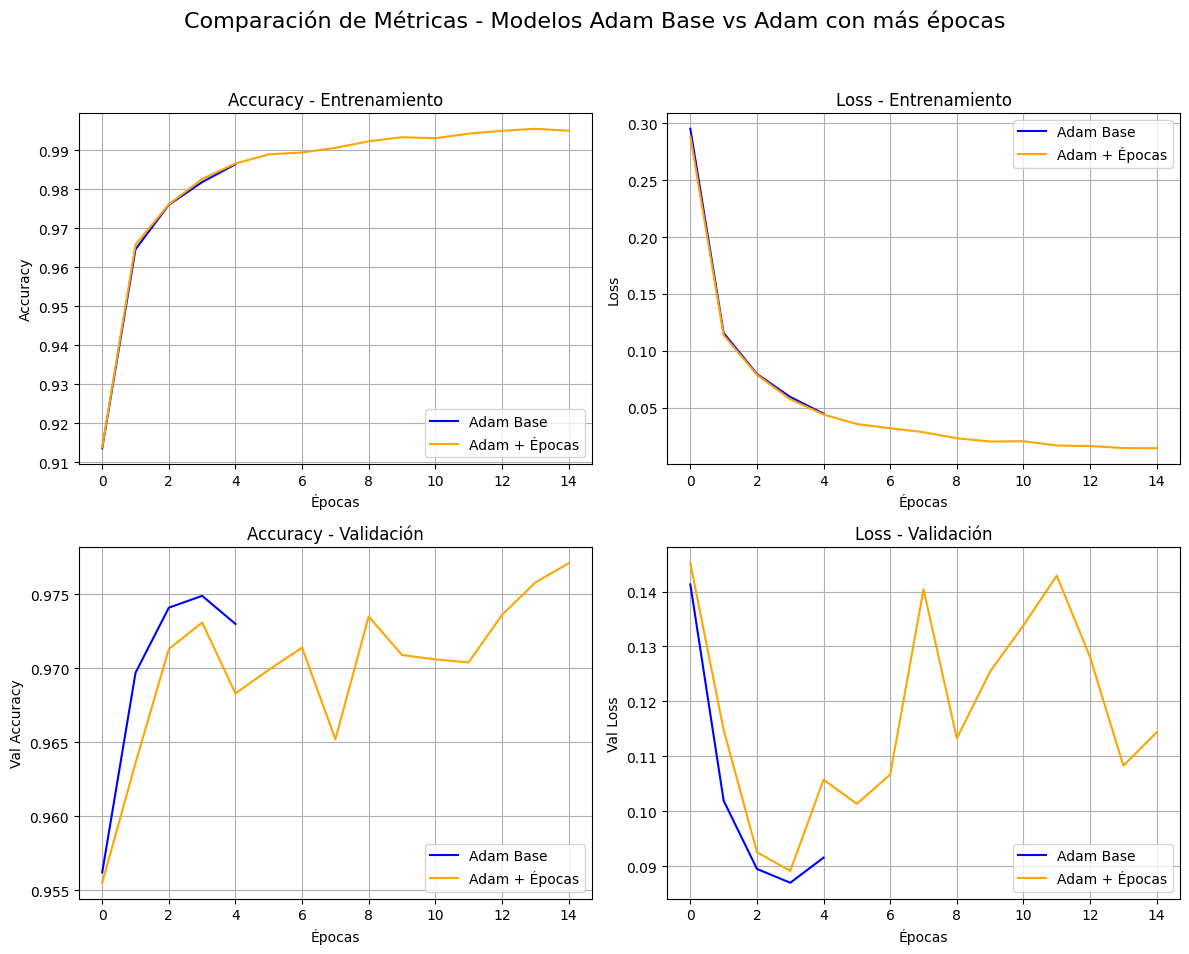

In [106]:
# Crear una figura con un grid 2x2
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Comparación de Métricas - Modelos Adam Base vs Adam con más épocas', fontsize=16)

# Gráfico 1: Accuracy en entrenamiento
axs[0, 0].plot(hist_adam.history['accuracy'], label='Adam Base', color='blue')
axs[0, 0].plot(hist_adam_epocas.history['accuracy'], label='Adam + Épocas', color='orange')
axs[0, 0].set_title('Accuracy - Entrenamiento')
axs[0, 0].set_xlabel('Épocas')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Gráfico 2: Loss en entrenamiento
axs[0, 1].plot(hist_adam.history['loss'], label='Adam Base', color='blue')
axs[0, 1].plot(hist_adam_epocas.history['loss'], label='Adam + Épocas', color='orange')
axs[0, 1].set_title('Loss - Entrenamiento')
axs[0, 1].set_xlabel('Épocas')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Gráfico 3: Accuracy en validación
axs[1, 0].plot(hist_adam.history['val_accuracy'], label='Adam Base', color='blue')
axs[1, 0].plot(hist_adam_epocas.history['val_accuracy'], label='Adam + Épocas', color='orange')
axs[1, 0].set_title('Accuracy - Validación')
axs[1, 0].set_xlabel('Épocas')
axs[1, 0].set_ylabel('Val Accuracy')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Gráfico 4: Loss en validación
axs[1, 1].plot(hist_adam.history['val_loss'], label='Adam Base', color='blue')
axs[1, 1].plot(hist_adam_epocas.history['val_loss'], label='Adam + Épocas', color='orange')
axs[1, 1].set_title('Loss - Validación')
axs[1, 1].set_xlabel('Épocas')
axs[1, 1].set_ylabel('Val Loss')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Ajustar el espaciado
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

La Red con más épocas presenta un mejor desempeño en accuracy tanto en entrenamiento (99.49%) como en validación (97.71%), superando a la red base. Aunque su loss de validación es ligeramente más alto, su mayor precisión en validación indica una mejor capacidad de generalización. Por lo tanto, se elige esta red, ya que ofrece un rendimiento superior en términos de exactitud, a pesar de una pequeña diferencia en la pérdida.

**Gráfico de comparación de los tiempos de entrenamiento de cada red**

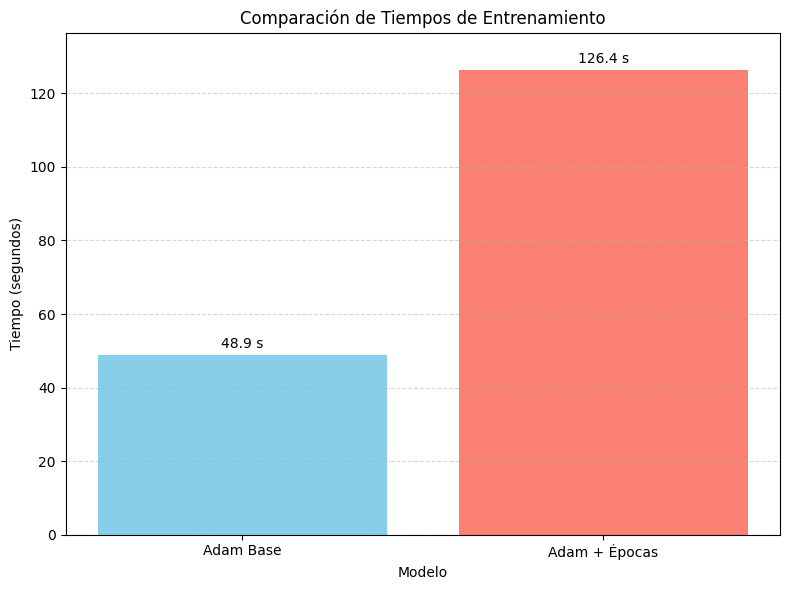

In [107]:
# Etiquetas y valores
modelos = ['Adam Base', 'Adam + Épocas']
tiempos = [time_base_adam, time_epocas_adam]

# Crear gráfico de barras
plt.figure(figsize=(8, 6))
bars = plt.bar(modelos, tiempos, color=['skyblue', 'salmon'])

# Agregar valores encima de las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.1f} s', ha='center', va='bottom')

# Estética
plt.title('Comparación de Tiempos de Entrenamiento')
plt.ylabel('Tiempo (segundos)')
plt.xlabel('Modelo')
plt.ylim(0, max(tiempos) + 10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Claramente, se puede observar que la red basada en el optimizador Adam es considerablemente más rápida en el entrenamiento cuando se entrena con menos épocas en comparación con la misma red entrenada durante 15 épocas. Esto se debe a que, con menos épocas, la red Adam logra un rendimiento similar en un tiempo significativamente menor. En términos de costo computacional, la red Adam es mucho más eficiente, ya que la diferencia en el tiempo de entrenamiento es casi 3 veces menor que la de la red con 15 épocas.

**Conclusión**

Basándonos en las métricas de accuracy y loss, el modelo con más épocas (15) es el mejor debido a que logra un accuracy superior tanto en el conjunto de entrenamiento (99.49%) como en el de validación (97.71%) en comparación con el modelo de 5 épocas, que obtiene 98.64% y 97.30% respectivamente. Aunque el modelo con 5 épocas tiene un loss ligeramente más bajo, el modelo con 15 épocas tiene un rendimiento general más alto en términos de precisión, lo que refleja una mejor capacidad de generalización y aprendizaje. Por lo tanto, el modelo con más épocas presenta un mejor equilibrio entre accuracy y desempeño.

## Adam (Adaptive Moment Estimation) con cambio en batcha size

### Arquitectura de la red

In [112]:
# Setea los seed para números random

np.random.seed(10)
tf.random.set_seed(10)


# Se crea la red feed-forward tiene 3 capas escondidas

h1 = 128
h2 = 64
h3 = 32

red_adam_batchsize = keras.Sequential(name="ADAM")
red_adam_batchsize.add(keras.layers.Input(shape=(N,), name='entrada'))
red_adam_batchsize.add(keras.layers.Dense(h1, activation='relu', name='primera_capa'))
red_adam_batchsize.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_adam_batchsize.add(keras.layers.Dense(h3, activation='relu', name='tercera_capa'))
red_adam_batchsize.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_adam_batchsize.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'F1Score'])

### Entrenamiento de la red

In [113]:
start_time_batchsize_adam = time()
hist_adam_batchsize = red_adam_batchsize.fit(X_train, y_train,
        epochs=15,
        batch_size=32,
        validation_data=(X_test,y_test)
        )
end_time_batchsize_adam = time()
time_batchsize_adam = end_time_batchsize_adam - start_time_batchsize_adam
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time_batchsize_adam - start_time_batchsize_adam))

red_adam_batchsize.save('red_adam_batchsize.h5')

Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - F1Score: 0.8607 - Precision: 0.9301 - Recall: 0.7920 - accuracy: 0.8633 - loss: 0.4607 - val_F1Score: 0.9566 - val_Precision: 0.9645 - val_Recall: 0.9509 - val_accuracy: 0.9570 - val_loss: 0.1344
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - F1Score: 0.9639 - Precision: 0.9707 - Recall: 0.9589 - accuracy: 0.9641 - loss: 0.1169 - val_F1Score: 0.9685 - val_Precision: 0.9741 - val_Recall: 0.9653 - val_accuracy: 0.9687 - val_loss: 0.0978
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - F1Score: 0.9765 - Precision: 0.9803 - Recall: 0.9734 - accuracy: 0.9767 - loss: 0.0788 - val_F1Score: 0.9702 - val_Precision: 0.9733 - val_Recall: 0.9682 - val_accuracy: 0.9705 - val_loss: 0.0991
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - F1Score: 0.9824 - Precision: 0.9851 - Recall: 0.9800 - accuracy: 0.9825 - loss: 0.0573 - val_F1Score: 0.9714 - val_Precision: 0.9741 - val_Recall: 0.9687 - val_accuracy: 0.9716 - val_l

Tiempo de entrenamiento: 178.3670761585 segundos


### Gráficos y conclusiones

**Gráfico de comparación en accuracy y en loss en entrenamiento y validación**

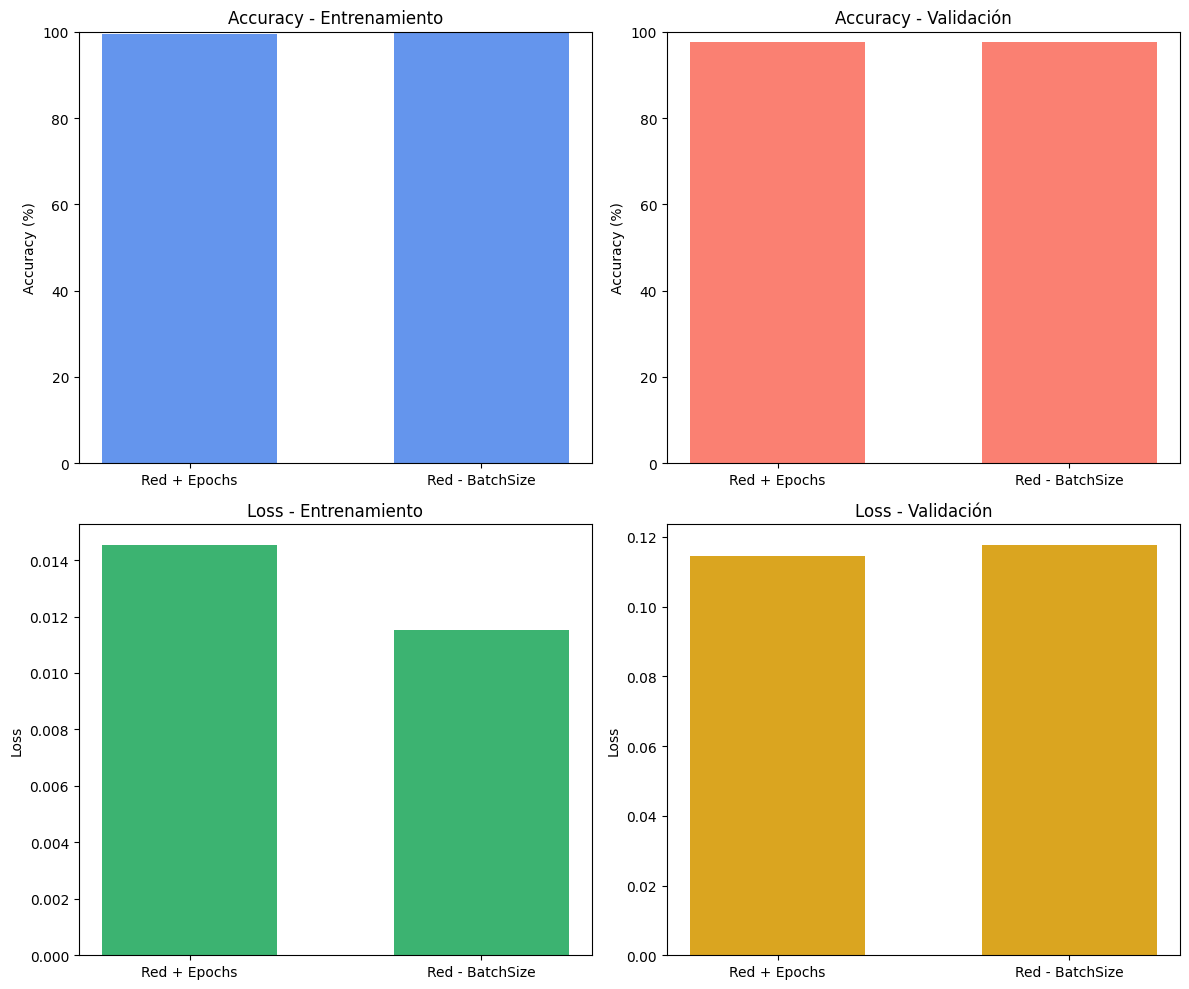

In [138]:
# Extraer métricas de ENTRENAMIENTO
accuracy_adam_epocas = hist_adam_epocas.history['accuracy'][-1] * 100
loss_adam_epocas = hist_adam_epocas.history['loss'][-1]

accuracy_adam_batchsize = hist_adam_batchsize.history['accuracy'][-1] * 100
loss_adam_batchsize = hist_adam_batchsize.history['loss'][-1]

# Extraer métricas de VALIDACIÓN
val_accuracy_adam_epocas = hist_adam_epocas.history['val_accuracy'][-1] * 100
val_loss_adam_epocas = hist_adam_epocas.history['val_loss'][-1]

val_accuracy_adam_batchsize = hist_adam_batchsize.history['val_accuracy'][-1] * 100
val_loss_adam_batchsize = hist_adam_batchsize.history['val_loss'][-1]

# Configuración general
labels = ['Red + Epochs', 'Red - BatchSize']
x = np.arange(len(labels))
width = 0.6

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Accuracy - Entrenamiento
axes[0, 0].bar(x, [accuracy_adam_epocas, accuracy_adam_batchsize], width, color='cornflowerblue')
axes[0, 0].set_title('Accuracy - Entrenamiento')
axes[0, 0].set_ylabel('Accuracy (%)')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(labels)
axes[0, 0].set_ylim(0, 100)

# Accuracy - Validación
axes[0, 1].bar(x, [val_accuracy_adam_epocas, val_accuracy_adam_batchsize], width, color='salmon')
axes[0, 1].set_title('Accuracy - Validación')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(labels)
axes[0, 1].set_ylim(0, 100)

# Loss - Entrenamiento
axes[1, 0].bar(x, [loss_adam_epocas, loss_adam_batchsize], width, color='mediumseagreen')
axes[1, 0].set_title('Loss - Entrenamiento')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(labels)

# Loss - Validación
axes[1, 1].bar(x, [val_loss_adam_epocas, val_loss_adam_batchsize], width, color='goldenrod')
axes[1, 1].set_title('Loss - Validación')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(labels)

# Ajustar espacio y mostrar
plt.tight_layout()
plt.show()

Tras analizar los gráficos comparativos de entrenamiento y validación, tanto en términos de accuracy como de loss, se observa que no existen diferencias significativas entre los modelos evaluados, ya que las métricas presentan comportamientos similares. Debido a esta similitud visual en los gráficos, se incorpora a continuación un cuadro comparativo con los valores cuantitativos de cada métrica. Esto permitirá una evaluación más precisa y detallada de las diferencias entre las configuraciones, facilitando así la elección del modelo más adecuado.

In [139]:
# Índices de filas
index = [
    'Capas ocultas',
    'Optimizer',
    'Épocas',
    'Batch size',
    'Activación',
    'Tiempo entrenamiento aprox.',
    'Accuracy final',
    'Loss final'
]

# Datos Red Base (original)
red_epocas_entrenamiento = [
    '3 (128 → 64 → 32)',
    'ADAM (lr=0.001)',
    '15',
    '64',
    'Relu',
    f'{time_epocas_adam:.2f} segundos',
    f'{accuracy_adam_epocas:.2f}%',
    f'{loss_adam_epocas:.4f}'
]

red_epocas_validacion = [
    '3 (128 → 64 → 32)',
    'ADAM (lr=0.001)',
    '15',
    '64',
    'Relu',
    f'{time_epocas_adam:.2f} segundos',
    f'{val_accuracy_adam_epocas:.2f}%',
    f'{val_loss_adam_epocas:.4f}'
]

# Datos Red con Más Épocas
red_batchsize_entrenamiento = [
    '3 (128 → 64 → 32)',
    'ADAM (lr=0.001)',
    '15',
    '32',
    'Relu',
    f'{time_batchsize_adam:.2f} segundos',
    f'{accuracy_adam_batchsize:.2f}%',
    f'{loss_adam_batchsize:.4f}'
]

red_batchsize_validacion = [
    '3 (128 → 64 → 32)',
    'ADAM (lr=0.001)',
    '15',
    '32',
    'Relu',
    f'{time_batchsize_adam:.2f} segundos',
    f'{val_accuracy_adam_batchsize:.2f}%',
    f'{val_loss_adam_batchsize:.4f}'
]

# Simular combinación de celdas para las primeras 3 filas en la Red Base
red_epocas_entrenamiento_mod = red_epocas_entrenamiento.copy()
red_epocas_validacion_mod = red_epocas_validacion.copy()

for i in range(6):  # 'Capas ocultas', 'Optimizer', 'Épocas'
    red_base_validacion_mod[i] = ''  # Dejar vacío para que parezca fusionado visualmente

# Simular combinación de celdas para las primeras 3 filas en la Red con Más Capas
red_batchsize_entrenamiento_mod = red_batchsize_entrenamiento.copy()
red_batchsize_validacion_mod = red_batchsize_validacion.copy()

for i in range(6):  # 'Capas ocultas', 'Optimizer', 'Épocas', etc.
    red_epocas_validacion_mod[i] = ''  # Dejar vacío para que parezca fusionado visualmente

for i in range(6):  # 'Capas ocultas', 'Optimizer', 'Épocas'
    red_batchsize_validacion_mod[i] = ''  # Dejar vacío para que parezca fusionado visualmente

# Crear MultiIndex para las columnas
columnas = pd.MultiIndex.from_product(
    [['Red con Más Épocas', 'Red con Menos Batch Size'], ['Entrenamiento', 'Validación']],
    names=['Modelo', 'Tipo']
)

# Crear DataFrame con los datos
data = list(zip(
    red_epocas_entrenamiento_mod, red_epocas_validacion_mod,
    red_batchsize_entrenamiento_mod, red_batchsize_validacion_mod
))

comparacion_epocas_df = pd.DataFrame(data, index=index, columns=columnas)

# Mostrar la tabla
display(comparacion_epocas_df)

Modelo                      Red con Más Épocas             \
Tipo                             Entrenamiento Validación   
Capas ocultas                3 (128 → 64 → 32)              
Optimizer                      ADAM (lr=0.001)              
Épocas                                      15              
Batch size                                  64              
Activación                                Relu              
Tiempo entrenamiento aprox.    126.45 segundos              
Accuracy final                          99.49%     97.71%   
Loss final                              0.0145     0.1144   

Modelo                      Red con Menos Batch Size             
Tipo                                   Entrenamiento Validación  
Capas ocultas                      3 (128 → 64 → 32)             
Optimizer                            ADAM (lr=0.001)             
Épocas                                            15             
Batch size                                        32             
Activación                                      Relu             
Tiempo entrenamiento aprox.          178.37 segundos             
Accuracy final                                99.62%     97.70%  
Loss final                                    0.0115     0.1178

Al comparar ambas redes, cuya arquitectura y parámetros son idénticos salvo por el batch size, se observa que la Red con Menor Batch Size (32) alcanza una precisión ligeramente superior en entrenamiento (99.62% vs 99.49%) y presenta una pérdida (loss) más baja (0.0115 vs 0.0145). Sin embargo, en validación ambas redes muestran un desempeño muy similar. Sin embargo, antes de tomar una decisión final, se procederá a comparar los tiempos de ejecución de ambos modelos, con el fin de realizar una elección más fundamentada.

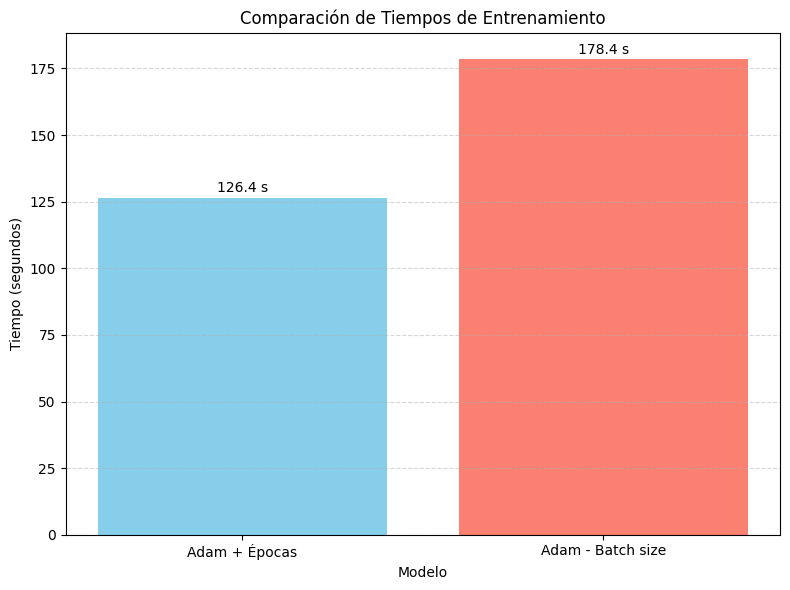

In [118]:
# Etiquetas y valores
modelos = ['Adam + Épocas', 'Adam - Batch size']
tiempos = [time_epocas_adam, time_batchsize_adam]

# Crear gráfico de barras
plt.figure(figsize=(8, 6))
bars = plt.bar(modelos, tiempos, color=['skyblue', 'salmon'])

# Agregar valores encima de las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.1f} s', ha='center', va='bottom')

# Estética
plt.title('Comparación de Tiempos de Entrenamiento')
plt.ylabel('Tiempo (segundos)')
plt.xlabel('Modelo')
plt.ylim(0, max(tiempos) + 10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Tras analizar los tiempos de ejecución, se evidencia que el costo computacional del modelo con menor batch size se demora 52 segundos más en comparación con el modelo de mayor batch size. No obstante, esta diferencia no representa un impacto significativo, ya que los tiempos de entrenamiento siguen siendo razonables y esto no implica una carga excesiva para el sistema. Por lo tanto, el aumento en el tiempo de ejecución es considerado aceptable en función del leve incremento en el rendimiento del modelo.

**Conclusión**

A partir del análisis comparativo entre ambas redes, las cuales comparten la misma arquitectura pero difieren en el tamaño del batch size, se observa que los resultados en cuanto a precisión y pérdida son muy similares. Sin embargo, la red entrenada con un batch size de 32 presenta una leve mejora tanto en la precisión como en la reducción de la pérdida, en comparación con la red que utilizó un batch size de 64. A pesar de que el tiempo de entrenamiento de la red con menor batch size se demora 52 segundos más, esta diferencia no representa una carga computacional significativa. Por lo tanto, dado que la red con batch size de 32 muestra una leve mejora en el rendimiento y el tiempo extra de entrenamiento no representa un problema importante, se considera que esta red es la opción más conveniente.

## Adam (Adaptive Moment Estimation) con cambio en el parametro de activación

### Arquitectura de la red

In [119]:
# Setea los seed para números random

np.random.seed(10)
tf.random.set_seed(10)


# Se crea la red feed-forward tiene 3 capas escondidas

h1 = 128
h2 = 64
h3 = 32

red_adam_activacion = keras.Sequential(name="ADAM")
red_adam_activacion.add(keras.layers.Input(shape=(N,), name='entrada'))
red_adam_activacion.add(keras.layers.Dense(h1, activation='elu', name='primera_capa'))
red_adam_activacion.add(keras.layers.Dense(h2, activation='elu', name='segunda_capa'))
red_adam_activacion.add(keras.layers.Dense(h3, activation='elu', name='tercera_capa'))
red_adam_activacion.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_adam_activacion.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'F1Score'])

### Entrenamiento de la red

In [120]:
start_time_validacion_adam = time()
hist_adam_elu = red_adam_activacion.fit(X_train, y_train,
        epochs=15,
        batch_size=32,
        validation_data=(X_test,y_test)
        )
end_time_validacion_adam = time()
time_validacion_adam = end_time_validacion_adam - start_time_validacion_adam
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time_validacion_adam - start_time_validacion_adam))

red_adam_activacion.save('red_adam_activacion.h5')

Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - F1Score: 0.8762 - Precision: 0.9295 - Recall: 0.8288 - accuracy: 0.8782 - loss: 0.4083 - val_F1Score: 0.9582 - val_Precision: 0.9659 - val_Recall: 0.9533 - val_accuracy: 0.9587 - val_loss: 0.1316
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - F1Score: 0.9615 - Precision: 0.9682 - Recall: 0.9561 - accuracy: 0.9618 - loss: 0.1278 - val_F1Score: 0.9665 - val_Precision: 0.9714 - val_Recall: 0.9633 - val_accuracy: 0.9669 - val_loss: 0.1053
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - F1Score: 0.9733 - Precision: 0.9774 - Recall: 0.9701 - accuracy: 0.9735 - loss: 0.0871 - val_F1Score: 0.9723 - val_Precision: 0.9758 - val_Recall: 0.9696 - val_accuracy: 0.9726 - val_loss: 0.0932
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - F1Score: 0.9796 - Precision: 0.9823 - Recall: 0.9780 - accuracy: 0.9797 - loss: 0.0635 - val_F1Score: 0.9714 - val_Precision: 0.9746 - val_Recall: 0.9700 - val_accuracy: 0.9716 - val_l

Tiempo de entrenamiento: 245.0141909122 segundos


### Gráficos y conclusiones

**Gráfico de comparacion de accuracy en entrenamiento y validación de Red con RELU y Red con ELU**

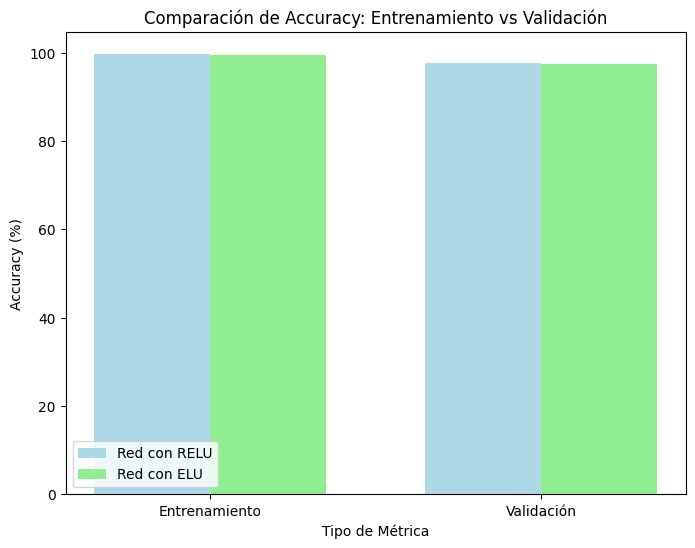

In [121]:
# Extraer accuracy de los resultados de entrenamiento
accuracy_adam_batchsize = hist_adam_batchsize.history['accuracy']
val_accuracy_adam_batchsize = hist_adam_batchsize.history['val_accuracy']
accuracy_adam_elu = hist_adam_elu.history['accuracy']
val_accuracy_adam_elu = hist_adam_elu.history['val_accuracy']

# Crear un gráfico de barras
labels = ['Entrenamiento', 'Validación']
batchsize_accuracy = [accuracy_adam_batchsize[-1]*100, val_accuracy_adam_batchsize[-1]*100]  # Último valor de accuracy
elu_accuracy = [accuracy_adam_elu[-1]*100, val_accuracy_adam_elu[-1]*100]  # Último valor de accuracy

x = range(len(labels))  # Posiciones en el eje X

# Crear el gráfico
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.35  # Ancho de las barras
ax.bar(x, batchsize_accuracy, bar_width, label='Red con RELU', color='lightblue')  # Color azul más claro
ax.bar([p + bar_width for p in x], elu_accuracy, bar_width, label='Red con ELU', color='lightgreen')  # Color verde más claro

# Personalizar el gráfico
ax.set_xlabel('Tipo de Métrica')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Comparación de Accuracy: Entrenamiento vs Validación')
ax.set_xticks([p + bar_width/2 for p in x])  # Alinea las etiquetas
ax.set_xticklabels(labels)

# Mover la leyenda a la esquina inferior izquierda
ax.legend(loc='lower left')

# Mostrar gráfico
plt.show()

Al analizar este gráfico, se observa que la diferencia en el rendimiento entre la red con activación RELU y la red con activación ELU no es significativa. Aunque la red con RELU presenta un desempeño ligeramente superior en cuanto a porcentaje de aciertos, se realizará una comparación adicional del loss antes de tomar una decisión sobre cuál de las dos arquitecturas es la más adecuada.

**Gráfico de comparacion de loss en entrenamiento y validación de Red con RELU y Red con ELU**

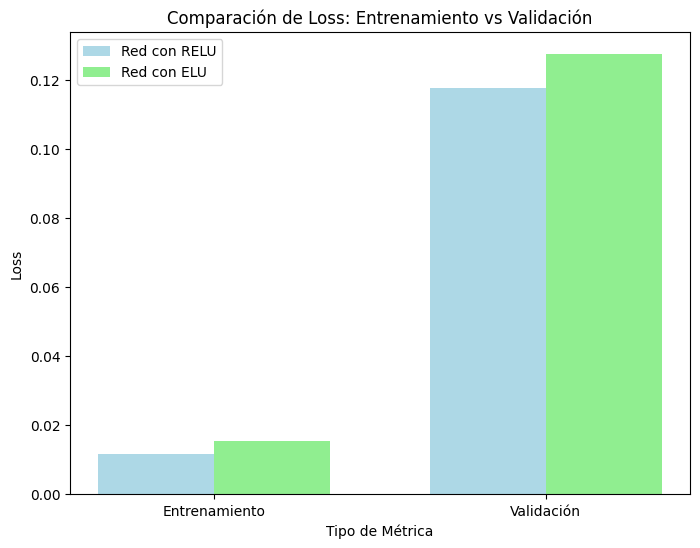

In [122]:
# Extraer loss de los resultados de entrenamiento
loss_adam_batchsize = hist_adam_batchsize.history['loss']
val_loss_adam_batchsize = hist_adam_batchsize.history['val_loss']
loss_adam_elu = hist_adam_elu.history['loss']
val_loss_adam_elu = hist_adam_elu.history['val_loss']

# Crear un gráfico de barras para el Loss
labels = ['Entrenamiento', 'Validación']
batchsize_loss = [loss_adam_batchsize[-1], val_loss_adam_batchsize[-1]]  # Último valor de loss
elu_loss = [loss_adam_elu[-1], val_loss_adam_elu[-1]]  # Último valor de loss

x = range(len(labels))  # Posiciones en el eje X

# Crear el gráfico
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.35  # Ancho de las barras
ax.bar(x, batchsize_loss, bar_width, label='Red con RELU', color='lightblue')  # Color azul más claro
ax.bar([p + bar_width for p in x], elu_loss, bar_width, label='Red con ELU', color='lightgreen')  # Color verde más claro

# Personalizar el gráfico
ax.set_xlabel('Tipo de Métrica')
ax.set_ylabel('Loss')
ax.set_title('Comparación de Loss: Entrenamiento vs Validación')
ax.set_xticks([p + bar_width/2 for p in x])  # Alinea las etiquetas
ax.set_xticklabels(labels)

# Mover la leyenda a la esquina superior izquierda
ax.legend(loc='upper left')

# Mostrar gráfico
plt.show()

"Al observar el gráfico que compara el loss, se puede apreciar que la red con RELU tiene una menor pérdida, lo cual sugiere que este modelo generaliza mejor, ya que, en general, un loss más bajo indica una mejor capacidad de generalización del modelo. Sin embargo, antes de tomar una decisión final sobre cuál modelo es más adecuado, procederé a comparar los tiempos de ejecución para obtener una evaluación más completa."

**Gráfico de comparacion de accuracy en entrenamiento y validación entre red con RELU y red con ELU**

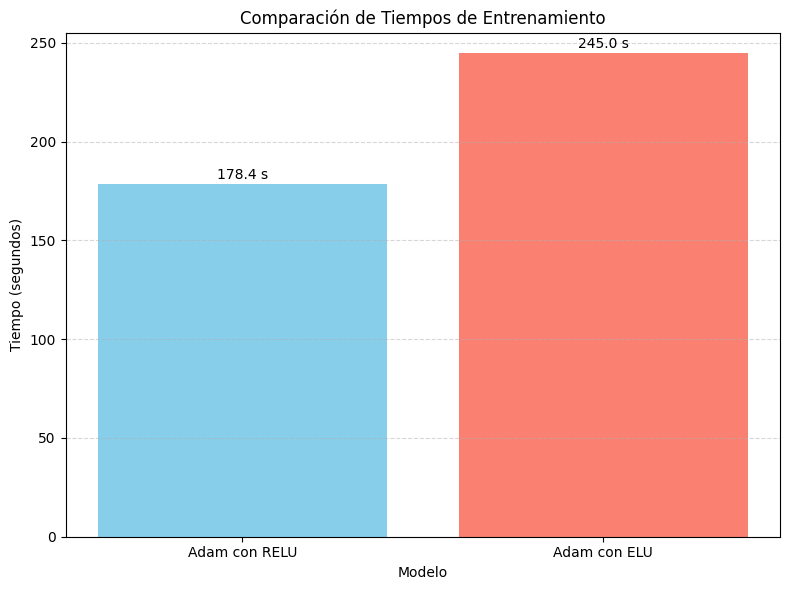

In [123]:
# Etiquetas y valores
modelos = ['Adam con RELU', 'Adam con ELU']
tiempos = [time_batchsize_adam, time_validacion_adam]

# Crear gráfico de barras
plt.figure(figsize=(8, 6))
bars = plt.bar(modelos, tiempos, color=['skyblue', 'salmon'])

# Agregar valores encima de las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.1f} s', ha='center', va='bottom')

# Estética
plt.title('Comparación de Tiempos de Entrenamiento')
plt.ylabel('Tiempo (segundos)')
plt.xlabel('Modelo')
plt.ylim(0, max(tiempos) + 10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Al analizar el gráfico de tiempos computacionales, se observa que la red con activación ReLU presenta un tiempo de ejecución ligeramente menor. No obstante, la diferencia es pequeña y no representa un impacto significativo en el rendimiento general del modelo.

**Conclusión**

Tras evaluar y comparar el accuracy, el loss y los tiempos de entrenamiento de ambas redes, se concluye que la red con ReLU ofrece un rendimiento superior en términos de precisión y generalización, además de contar con un tiempo de entrenamiento ligeramente menor. Aunque la diferencia en tiempo frente a la red con ELU es mínima, se prioriza el mejor desempeño en precisión y menor pérdida, ya que estos factores son fundamentales para la calidad del modelo, por sobre el costo computacional.

## Adam (Adaptive Moment Estimation) con drop out

### Arquitectura de la red

In [124]:
# Setea los seed para números random

np.random.seed(10)
tf.random.set_seed(10)


# Se crea la red feed-forward tiene 3 capas escondidas

h1 = 128
h2 = 64
h3 = 32

red_adam_dropout = keras.Sequential(name="ADAM")
red_adam_dropout.add(keras.layers.Input(shape=(N,), name='entrada'))
red_adam_dropout.add(keras.layers.Dense(h1, activation='relu', name='primera_capa'))
red_adam_dropout.add(keras.layers.Dropout(0.15))
red_adam_dropout.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_adam_dropout.add(keras.layers.Dropout(0.15))
red_adam_dropout.add(keras.layers.Dense(h3, activation='relu', name='tercera_capa'))
red_adam_dropout.add(keras.layers.Dropout(0.15))
red_adam_dropout.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_adam_dropout.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'F1Score'])

### Entrenamiento de la red

In [125]:
start_time_dropout_adam = time()
hist_adam_dropout = red_adam_dropout.fit(X_train, y_train,
        epochs=15,
        batch_size=32,
        validation_data=(X_test,y_test)
        )
end_time_dropout_adam = time()
time_dropout_adam = end_time_dropout_adam - start_time_dropout_adam
print("Tiempo de entrenamiento: %0.10f segundos" % (end_time_dropout_adam - start_time_dropout_adam))

red_adam_dropout.save('red_adam_dropout.h5')

Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - F1Score: 0.8014 - Precision: 0.8988 - Recall: 0.7211 - accuracy: 0.8043 - loss: 0.6216 - val_F1Score: 0.9560 - val_Precision: 0.9645 - val_Recall: 0.9490 - val_accuracy: 0.9565 - val_loss: 0.1372
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - F1Score: 0.9485 - Precision: 0.9609 - Recall: 0.9394 - accuracy: 0.9489 - loss: 0.1746 - val_F1Score: 0.9653 - val_Precision: 0.9707 - val_Recall: 0.9615 - val_accuracy: 0.9657 - val_loss: 0.1153
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - F1Score: 0.9595 - Precision: 0.9683 - Recall: 0.9526 - accuracy: 0.9599 - loss: 0.1374 - val_F1Score: 0.9716 - val_Precision: 0.9772 - val_Recall: 0.9680 - val_accuracy: 0.9719 - val_loss: 0.0962
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - F1Score: 0.9671 - Precision: 0.9742 - Recall: 0.9615 - accuracy: 0.9674 - loss: 0.1130 - val_F1Score: 0.9766 - val_Precision: 0.9803 - val_Recall: 0.9723 - val_accuracy: 0.9768 - val_l

Tiempo de entrenamiento: 229.3404514790 segundos


### Gráficos y conclusiones

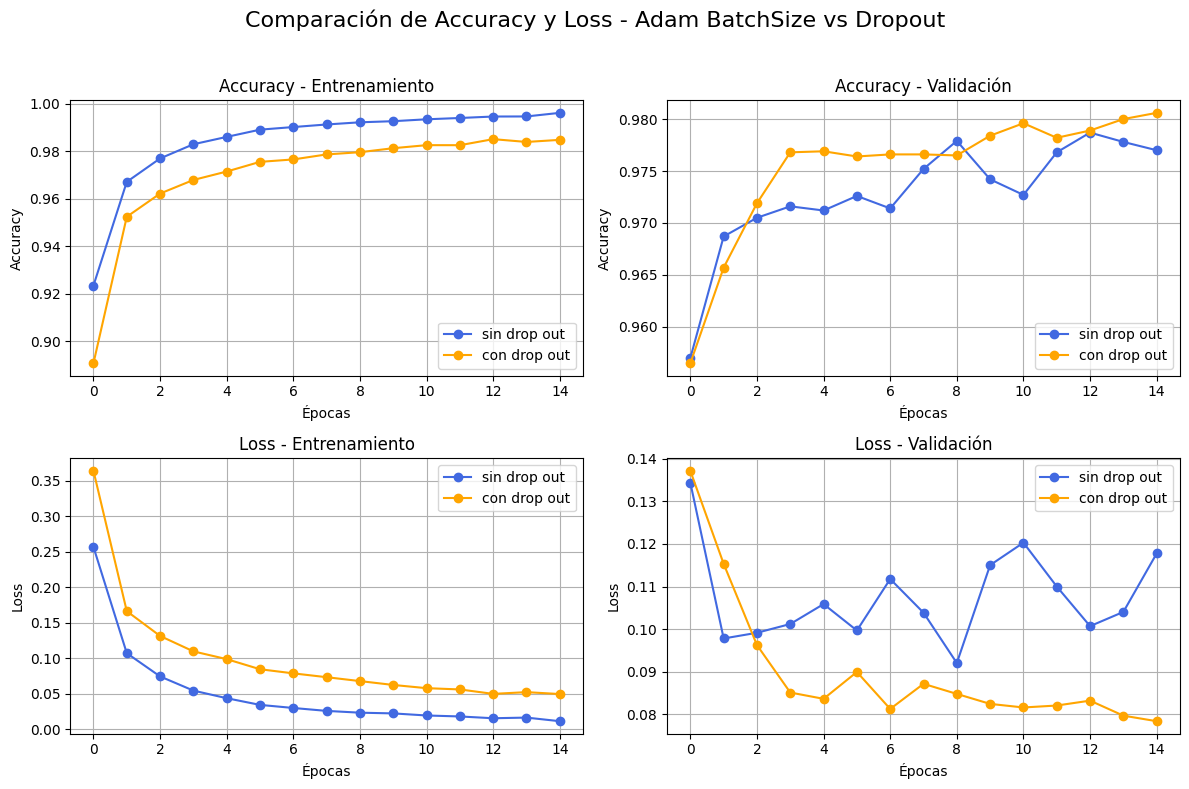

In [126]:
# Crear figura y ejes
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Comparación de Accuracy y Loss - Adam BatchSize vs Dropout', fontsize=16)

# Accuracy de entrenamiento
axs[0, 0].plot(hist_adam_batchsize.history['accuracy'], label='sin drop out', color='royalblue', marker='o')
axs[0, 0].plot(hist_adam_dropout.history['accuracy'], label='con drop out', color='orange', marker='o')
axs[0, 0].set_title('Accuracy - Entrenamiento')
axs[0, 0].set_xlabel('Épocas')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend(loc='lower right')
axs[0, 0].grid(True)

# Accuracy de validación
axs[0, 1].plot(hist_adam_batchsize.history['val_accuracy'], label='sin drop out', color='royalblue', marker='o')
axs[0, 1].plot(hist_adam_dropout.history['val_accuracy'], label='con drop out', color='orange', marker='o')
axs[0, 1].set_title('Accuracy - Validación')
axs[0, 1].set_xlabel('Épocas')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend(loc='lower right')
axs[0, 1].grid(True)

# Loss de entrenamiento
axs[1, 0].plot(hist_adam_batchsize.history['loss'], label='sin drop out', color='royalblue', marker='o')
axs[1, 0].plot(hist_adam_dropout.history['loss'], label='con drop out', color='orange', marker='o')
axs[1, 0].set_title('Loss - Entrenamiento')
axs[1, 0].set_xlabel('Épocas')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend(loc='upper right')
axs[1, 0].grid(True)

# Loss de validación
axs[1, 1].plot(hist_adam_batchsize.history['val_loss'], label='sin drop out ', color='royalblue', marker='o')
axs[1, 1].plot(hist_adam_dropout.history['val_loss'], label='con drop out', color='orange', marker='o')
axs[1, 1].set_title('Loss - Validación')
axs[1, 1].set_xlabel('Épocas')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend(loc='upper right')
axs[1, 1].grid(True)

# Ajustar el diseño del gráfico
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Al analizar los gráficos comparativos, se observa que la variación en el accuracy entre las dos redes, tanto en entrenamiento como en validación, es de aproximadamente un punto porcentual. Esta diferencia es poco significativa y no permite establecer, por sí sola, una clara superioridad de una red sobre la otra. No obstante, al examinar la métrica de loss, se aprecia una diferencia más notoria, particularmente en la fase de validación, donde el modelo que incorpora la técnica de Dropout presenta una menor pérdida. Esto sugiere una mejor capacidad de generalización y mayor robustez frente a datos no vistos. Dado que el tiempo de entrenamiento se mantiene dentro de rangos razonables, se puede concluir que el uso de Dropout aporta una mejora en el desempeño global del modelo sin afectar significativamente la eficiencia computacional.

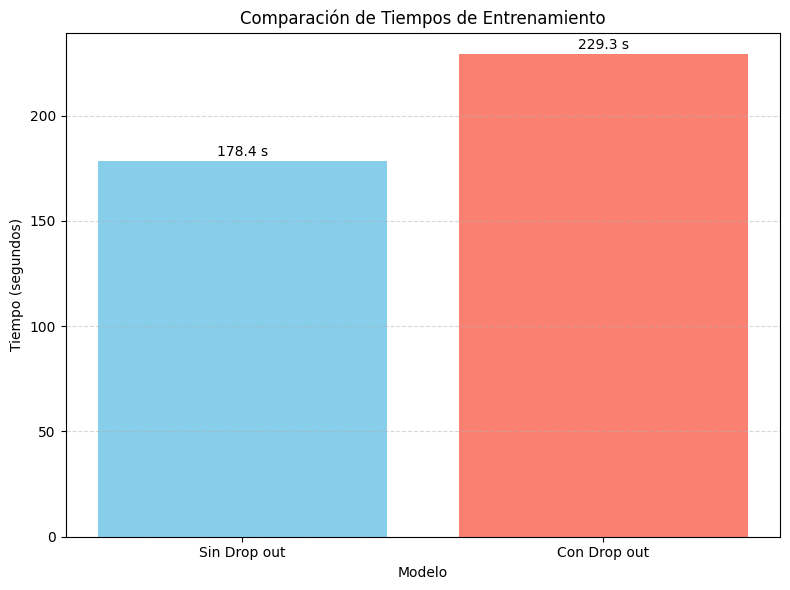

In [127]:
# Etiquetas y valores
modelos = ['Sin Drop out', 'Con Drop out']
tiempos = [time_batchsize_adam, time_dropout_adam]

# Crear gráfico de barras
plt.figure(figsize=(8, 6))
bars = plt.bar(modelos, tiempos, color=['skyblue', 'salmon'])

# Agregar valores encima de las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.1f} s', ha='center', va='bottom')

# Estética
plt.title('Comparación de Tiempos de Entrenamiento')
plt.ylabel('Tiempo (segundos)')
plt.xlabel('Modelo')
plt.ylim(0, max(tiempos) + 10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Al observar el gráfico correspondiente a los tiempos de entrenamiento, se aprecia con claridad que la red que incorpora la técnica de Dropout presenta un mayor costo computacional en comparación con la red que no la utiliza. Esto indica que, aunque el Dropout puede contribuir a una mejor capacidad de generalización, su uso implica una mayor demanda de tiempo de entrenamiento para este caso. Sin embargo, la diferencia en los tiempos no resulta significativa, por lo que se opta por dar mayor relevancia a la función de pérdida, ya que en este aspecto es donde se reflejan con más claridad las diferencias en el desempeño de los modelos.

Conclusión final de las pruebas al modelo Adam

Durante la fase experimental con el modelo que utilizó el optimizador Adam, se partió desde una configuración base que incluía la función de activación ReLU, una tasa de aprendizaje de 0.001, 5 épocas de entrenamiento, un batch size de 64 y sin la implementación de Dropout. A partir de esta arquitectura inicial, se evaluaron distintas variantes del modelo con el objetivo de mejorar su desempeño en términos de precisión y generalización.

Entre los ajustes explorados se encuentran: la comparación entre las funciones de activación ReLU y ELU, así como la incorporación de una tasa de Dropout del 15%. Los resultados obtenidos indicaron que la red con función ReLU presentó un comportamiento más favorable que su contraparte con ELU, tanto en precisión como en pérdida, especialmente durante la fase de validación. Adicionalmente, la introducción de Dropout permitió reducir el sobreajuste sin comprometer significativamente la precisión del modelo.

A pesar de que la red con sin Dropout implicó un costo computacional menor, esta diferencia no fue lo suficientemente significativa como para afectar la elección final. Por lo tanto, considerando tanto el rendimiento en accuracy como la capacidad de generalización evidenciada en la pérdida de validación, se concluye que la arquitectura con activación ReLU y Dropout ofrece el mejor desempeño general entre las variantes probadas utilizando el optimizador Adam.

## Comparación de las mejores redes de los distintos optimizadores  

**Tabla comparativa de las mejores redes de cada optimizador**

In [140]:
# Extraer métricas de ENTRENAMIENTO de ambos modelos
accuracy_dropout = hist_sgd_dropout.history['accuracy'][-1] * 100
f1_score_dropout = hist_sgd_dropout.history['F1Score'][-1][-1]
loss_dropout = hist_sgd_dropout.history['loss'][-1]
precision_dropout = hist_sgd_dropout.history['Precision'][-1]

accuracy_dropout_adam = hist_adam_dropout.history['accuracy'][-1] * 100
f1_score_dropout_adam = hist_adam_dropout.history['F1Score'][-1][-1]
loss_dropout_adam = hist_adam_dropout.history['loss'][-1]
precision_dropout_adam = hist_adam_dropout.history['Precision'][-1]


# Extraer métricas de VALIDACIÓN de ambos modelos
val_accuracy_dropout = hist_sgd_dropout.history['val_accuracy'][-1] * 100
val_f1_score_dropout = hist_sgd_dropout.history['val_F1Score'][-1][-1]
val_loss_dropout = hist_sgd_dropout.history['val_loss'][-1]
val_precision_dropout = hist_sgd_dropout.history['val_Precision'][-1]

val_accuracy_dropout_adam = hist_adam_dropout.history['val_accuracy'][-1] * 100
val_f1_score_dropout_adam = hist_adam_dropout.history['val_F1Score'][-1][-1]
val_loss_dropout_adam = hist_adam_dropout.history['val_loss'][-1]
val_precision_dropout_adam = hist_adam_dropout.history['val_Precision'][-1]

# Índices de filas
index = [
    'Capas ocultas',
    'Optimizer',
    'Épocas',
    'Batch size',
    'Función de activación',
    'Tiempo entrenamiento aprox.',
    'Accuracy final',
    'F1-Score final',
    'Precision final',
    'Loss final'
]

# Datos Red Base (original)
red_sgd_entrenamiento = [
    '3 (128 → 64 → 32)',
    'SGD (lr=0.01)',
    '15',
    '32',
    'Relu',
    f'{time_dropout:.2f} segundos',
    f'{accuracy_dropout:.2f}%',
    f'{f1_score_dropout:.4f}',
    f'{precision_dropout:.4f}',
    f'{loss_dropout:.4f}'
]

red_sgd_validacion = [
    '3 (128 → 64 → 32)',
    'SGD (lr=0.01)',
    '15',
    '32',
    'Relu',
    f'{time_dropout:.2f} segundos',
    f'{val_accuracy_dropout:.2f}%',
    f'{val_f1_score_dropout:.4f}',
    f'{val_precision_dropout:.4f}',
    f'{val_loss_dropout:.4f}'
]

# Datos Red con Más Épocas
red_adam_entrenamiento = [
    '3 (128 → 64 → 32)',
    'ADAM (lr=0.001)',
    '15',
    '32',
    'Relu',
    f'{time_dropout_adam:.2f} segundos',
    f'{accuracy_dropout_adam:.2f}%',
    f'{f1_score_dropout_adam:.4f}',
    f'{precision_dropout_adam:.4f}',
    f'{loss_dropout_adam:.4f}'
]

red_adam_validacion = [
    '3 (128 → 64 → 32)',
    'ADAM (lr=0.001)',
    '15',
    '32',
    'Relu',
    f'{time_dropout_adam:.2f} segundos',
    f'{val_accuracy_dropout_adam:.2f}%',
    f'{val_f1_score_dropout_adam:.4f}',
    f'{val_precision_dropout_adam:.4f}',
    f'{val_loss_dropout_adam:.4f}'
]

# Simular combinación de celdas para las primeras 4 filas (hasta Batch size incluido)
red_sgd_entrenamiento = red_sgd_entrenamiento.copy()
red_sgd_validacion = red_sgd_validacion.copy()
red_adam_entrenamiento = red_adam_entrenamiento.copy()
red_adam_validacion = red_adam_validacion.copy()

for i in range(6):  # 'Capas ocultas', 'Optimizer', 'Épocas', 'Batch size'
    red_sgd_validacion[i] = ''  # Dejar vacío para simular celda combinada
    red_adam_validacion[i] = ''

# Crear MultiIndex para las columnas
columnas = pd.MultiIndex.from_product(
    [['Red SGD', 'Red ADAM'], ['Entrenamiento', 'Validación']],
    names=['Modelo', 'Tipo']
)

# Crear DataFrame con los datos
data = list(zip(
    red_sgd_entrenamiento, red_sgd_validacion,
    red_adam_entrenamiento, red_adam_validacion
))

comparacion_activacion_df = pd.DataFrame(data, index=index, columns=columnas)

# Mostrar la tabla
display(comparacion_activacion_df)

Modelo                                 Red SGD                      Red ADAM  \
Tipo                             Entrenamiento Validación      Entrenamiento   
Capas ocultas                3 (128 → 64 → 32)             3 (128 → 64 → 32)   
Optimizer                        SGD (lr=0.01)               ADAM (lr=0.001)   
Épocas                                      15                            15   
Batch size                                  32                            32   
Función de activación                     Relu                          Relu   
Tiempo entrenamiento aprox.    142.54 segundos               229.34 segundos   
Accuracy final                          96.40%     97.37%             98.48%   
F1-Score final                          0.9489     0.9664             0.9777   
Precision final                         0.9726     0.9787             0.9867   
Loss final                              0.1226     0.0889             0.0498   

Modelo                                  
Tipo                        Validación  
Capas ocultas                           
Optimizer                               
Épocas                                  
Batch size                              
Función de activación                   
Tiempo entrenamiento aprox.             
Accuracy final                  98.06%  
F1-Score final                  0.9752  
Precision final                 0.9828  
Loss final                      0.0783

En la siguiente tabla se presentan las diferencias entre las redes con mejor desempeño correspondientes a cada optimizador. Posteriormente, se incluyen representaciones gráficas que permiten visualizar de manera más clara y comparativa las diferencias observadas en los resultados obtenidos.

**Gráfico de diferencia de accuracy entre las mejores redes de cada optimizador**

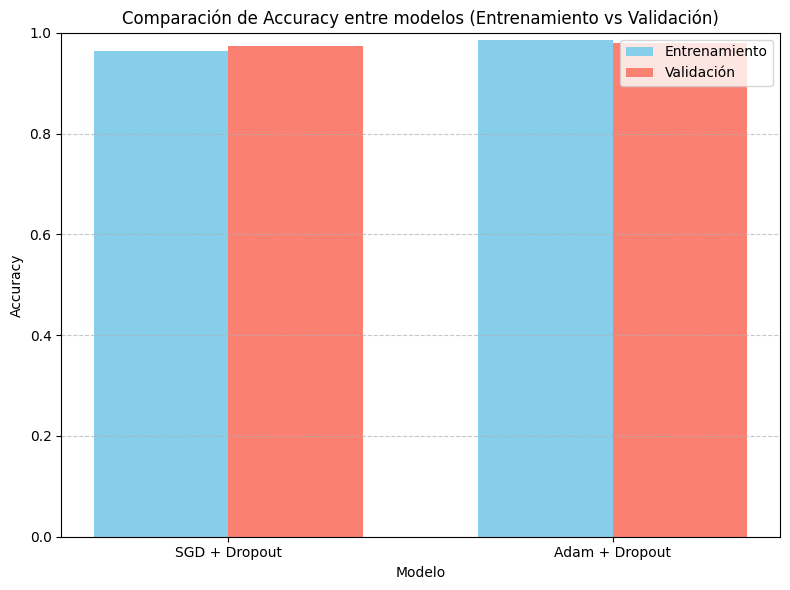

In [128]:
# Extraer accuracy final
acc_sgd = hist_sgd_dropout.history['accuracy'][-1]
val_acc_sgd = hist_sgd_dropout.history['val_accuracy'][-1]

acc_adam = hist_adam_dropout.history['accuracy'][-1]
val_acc_adam = hist_adam_dropout.history['val_accuracy'][-1]

# Datos para las gráficas
modelos = ['SGD + Dropout', 'Adam + Dropout']
train_acc = [acc_sgd, acc_adam]
val_acc = [val_acc_sgd, val_acc_adam]

# Ancho de las barras
bar_width = 0.35
index = np.arange(len(modelos))

# Gráfico
plt.figure(figsize=(8, 6))
plt.bar(index, train_acc, bar_width, label='Entrenamiento', color='skyblue')
plt.bar(index + bar_width, val_acc, bar_width, label='Validación', color='salmon')

plt.xlabel('Modelo')
plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy entre modelos (Entrenamiento vs Validación)')
plt.xticks(index + bar_width / 2, modelos)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Se observa que la diferencia en los valores de accuracy entre ambos modelos es relativamente pequeña, lo cual dificulta establecer con claridad cuál de ellos presenta un mejor rendimiento en términos de esta métrica. Dado lo anterior, se procede a analizar la función de pérdida (loss) con el fin de obtener una evaluación más precisa del desempeño de cada red.

**Gráfico de diferencia de loss entre las mejores redes de cada optimizador**

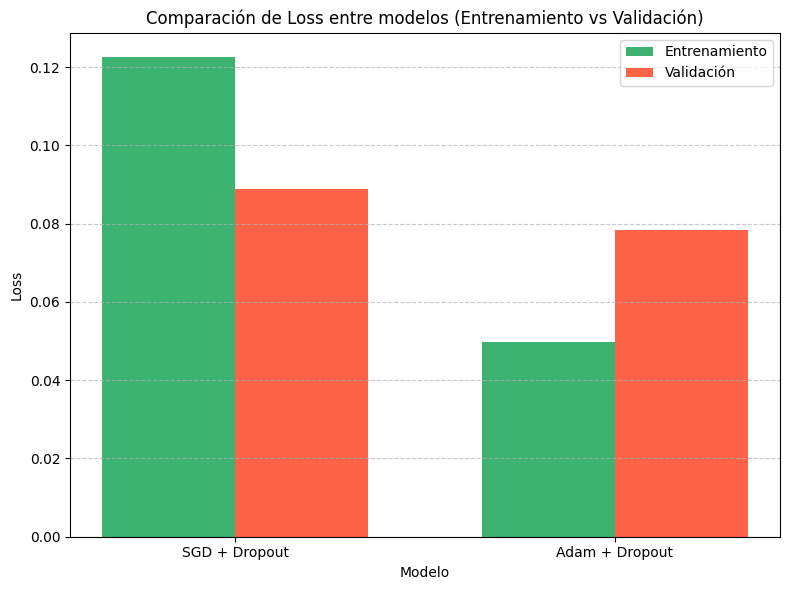

In [129]:
# Extraer loss final
loss_sgd = hist_sgd_dropout.history['loss'][-1]
val_loss_sgd = hist_sgd_dropout.history['val_loss'][-1]

loss_adam = hist_adam_dropout.history['loss'][-1]
val_loss_adam = hist_adam_dropout.history['val_loss'][-1]

# Labels y datos
modelos = ['SGD + Dropout', 'Adam + Dropout']
train_loss = [loss_sgd, loss_adam]
val_loss = [val_loss_sgd, val_loss_adam]

# Configuración del gráfico
bar_width = 0.35
index = np.arange(len(modelos))

plt.figure(figsize=(8, 6))
plt.bar(index, train_loss, bar_width, label='Entrenamiento', color='mediumseagreen')
plt.bar(index + bar_width, val_loss, bar_width, label='Validación', color='tomato')

plt.xlabel('Modelo')
plt.ylabel('Loss')
plt.title('Comparación de Loss entre modelos (Entrenamiento vs Validación)')
plt.xticks(index + bar_width / 2, modelos)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Al analizar el gráfico de comparación de la función de pérdida (loss), se aprecia con claridad que el modelo entrenado con el optimizador Adam y la técnica de dropout presenta un menor valor de pérdida tanto en el conjunto de entrenamiento como en el de validación. Esto sugiere una mayor capacidad de generalización, lo cual constituye un argumento sólido para considerar este modelo como el de mejor desempeño entre los dos evaluados. Sin embargo, antes de establecer una conclusión definitiva, se analizará el tiempo de entrenamiento requerido por cada red.

**Gráfico de diferencia de tiempo de entrenamiento entre los mejores modelos de cada optimizador**

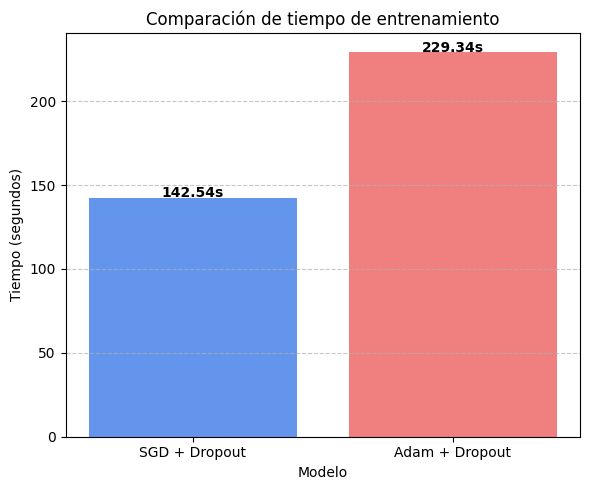

In [130]:
# Tiempos de entrenamiento (ya calculados)
tiempos = [time_dropout, time_dropout_adam]
modelos = ['SGD + Dropout', 'Adam + Dropout']

# Gráfico
plt.figure(figsize=(6, 5))
plt.bar(modelos, tiempos, color=['cornflowerblue', 'lightcoral'])

plt.xlabel('Modelo')
plt.ylabel('Tiempo (segundos)')
plt.title('Comparación de tiempo de entrenamiento')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar valores encima de las barras
for i, v in enumerate(tiempos):
    plt.text(i, v + 0.1, f'{v:.2f}s', ha='center', fontweight='bold')

plt.show()

Al observar el gráfico, se evidencia que el modelo entrenado con el optimizador Adam y la técnica de dropout presenta un mayor costo computacional en comparación con el modelo basado en SGD con dropout. Sin embargo, esta diferencia no es significativa, ya que el tiempo de entrenamiento adicional es de aproximadamente 4 minutos, lo cual se considera un tiempo razonable. Por lo tanto, no se tomará en cuenta el tiempo de ejecución como un factor determinante para decidir cuál de los modelos es superior.

# conclusión final de la experimentación



Considerando que las redes con dropout y diferentes optimizadores presentan diferencias mínimas en cuanto a accuracy y que los tiempos de entrenamiento son razonables, se toma la decisión de determinar cuál modelo es superior basándose en la función de pérdida (loss). Esto se debe a que es en esta métrica donde se observa una diferencia notable, siendo el modelo Adam con dropout el que presenta una menor pérdida en comparación con el modelo SGD con dropout, lo que indica un mejor desempeño en términos de generalización.